# Make plots of both MOM6 and MITgcm ISOMIP results

In [1]:
from MITgcmutils import mds

#Load required packages
%matplotlib inline
import matplotlib.pyplot as plt
import xarray as xr
from xgcm import Grid
import numpy as np
import pandas as pd
import cftime
import IPython.display
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
import sys, os
import warnings
warnings.simplefilter("ignore")
from dask.distributed import Client

from xhistogram.xarray import histogram


In [2]:
client = Client()
client

<Client: 'tcp://127.0.0.1:35917' processes=7 threads=7, memory=32.00 GiB>

In [3]:
base_folder_MIT = '/scratch/x77/cy8964/gadi_short/cy8964/mitgcm/archive/'
#base_folder_MIT = '/g/data/x77/cy8964/mitgcm/archive/'

list_folders_MIT = ['run-J10-warm-utide','run-R22-warm-utide', 
                'run-J10-cold-utide','run-R22-cold-utide',
                'run-J10-warm-ustarmin','run-R22-warm-ustarmin',
                'run-J10-cold-ustarmin','run-R22-cold-ustarmin',
                #'run-HJ99-warm-utide', 'run-HJ99-cold-utide',
                #'run-R22-warm-utide-nk72',
                #'run-R22-cold-convectivelimit',
                #'run-R22-warm-convectivelimit',
                'run-J10-warm-convectivelimitlocal','run-R22-warm-convectivelimitlocal',
                'run-J10-cold-convectivelimitlocal','run-R22-cold-convectivelimitlocal',
                ]
no_configs_MIT = len(list_folders_MIT)

In [4]:
def open_files_MIT(i):
    folder = base_folder_MIT+list_folders_MIT[i]+'/output001/'
    folder1 = base_folder_MIT+list_folders_MIT[i]+'/output000/'
    
    grid = xr.open_dataset(folder1 + 'grid.nc')    
    tave = xr.open_dataset(folder + 'tave.nc')
    shelficetave = xr.open_dataset(folder + 'shelfice_tave.nc')
    shelfsnap = xr.open_dataset(folder + 'shelfsnap.nc')
    return grid, tave, shelficetave, shelfsnap

In [5]:
# melt in kg/m^2/s to m/yr = multiply by #seconds per year, divide by rho_0
s_to_yr = 365*24*3600
rho0 = 1000

In [9]:
def plot_transect_MIT(ax, i, y, var, time_slice, vmin, vmax, cmap):
    grid, tave, shelficetave, shelfsnap = open_files_MIT(i)
    if var == 'vVeltave':
        plotvar = tave[var].isel(T = time_slice, Yp1 = y).mean('T')
        X = tave.X
    elif var == 'uVeltave':
        plotvar = tave[var].isel(T = time_slice, Y = y).mean('T')
        X = tave.Xp1
    else:
        plotvar = tave[var].isel(T = time_slice, Y = y).mean('T')
        X = tave.X

    plotvar = plotvar.where(plotvar !=0)
    mesh = ax.pcolormesh(
    1e-3 * X, -plotvar.Z.values, plotvar.values, 
    cmap=cmap, vmin=vmin, vmax=vmax, shading='nearest')
    #plt.colorbar(mesh, ax = ax, label = 'T ($^\circ$C)')
    ax.set_title(var+', '+list_folders_MIT[i])
    ax.set_ylabel('Depth (m)')
    ax.set_xlabel('x (km)')
    ax.set_ylim(720,0)
    return mesh
        
def plot_melt_MIT(ax, i, time_slice, vmin, vmax):
    grid, tave, shelficetave, shelfsnap = open_files_MIT(i)
    melt = -s_to_yr/rho0*shelficetave.fwFluxtave.isel(T = time_slice).mean('T')
    mesh = ax.pcolormesh(
    1e-3 * melt.X, 1e-3 * melt.Y, melt.values, 
    cmap=cm.cm.balance, vmin=vmin, vmax=vmax, shading='nearest')
    #plt.colorbar(mesh, ax = ax, label = 'melt, m/yr')
    ax.set_title('melt, '+list_folders_MIT[i])
    ax.set_ylabel('y (km)')
    ax.set_xlabel('x (km)')
    print('Total Melt for '+list_folders_MIT[i]+' experiment = '+str(melt.where(melt !=0).mean().values)+' m/yr')
    return mesh, melt.where(melt!=0).mean()
    
def plot_melt_timeseries_MIT(ax, i):
    grid, tave, shelficetave, shelfsnap = open_files_MIT(i)
    time = np.arange(len(shelficetave.fwFluxtave))
    melt = -s_to_yr/rho0*shelficetave.fwFluxtave.where(shelficetave.fwFluxtave !=0).mean(['X','Y'])
    print(list_folders_MIT[i])
    print('melt at day -1 = '+str(melt.isel(T = -1).values))
    ax.plot(time, melt, label = list_folders_MIT[i])
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Melt, averaged over shelf (m/yr)')

def compute_melt_MIT(i,time_slice):
    grid, tave, shelficetave, shelfsnap = open_files_MIT(i)
    melt = -s_to_yr/rho0*shelficetave.fwFluxtave.isel(T = time_slice).mean('T')
    melt = melt.where(melt!=0).mean(['X','Y']).values
    return melt

In [7]:
def plot_rhooverturning_MIT(ax, i, time_slice, vmin, vmax):
    gridnc, tave, shelficetave, shelfsnap = open_files_MIT(i)
    grid = Grid(tave.isel(T = time_slice), coords={'Z': {'center':'Z','outer':'Zl'}, 
                          'X': {'center':'X','outer':'Xp1'},
                          'Y': {'center':'Y','outer':'Yp1'}}, periodic=False)
    u_transport = tave.uVeltave.isel(T = time_slice) * gridnc.dyG * gridnc.HFacW * gridnc.drF
    tAlpha = 3.733E-5
    sBeta = 7.843E-4
    rhoNil = 1027.51
    rho = rhoNil*(sBeta*(tave.Stave.isel(T = time_slice)-(34.2))-tAlpha*(tave.Ttave.isel(T = time_slice)+1))+(rhoNil)
    rho = grid.interp(rho,'X').rename('rho')
    rhobins = np.linspace(1027,1027.85,51) #1027.85,1027
    u_transport_rho = histogram(rho, bins=[rhobins], dim = ['Z'],weights=u_transport)
    print( u_transport_rho.shape)
    Psi = (u_transport_rho.cumsum('rho_bin').sum('Y').mean('T'))/1e6
    rhorho,XX,  = np.meshgrid(Psi.rho_bin,Psi.Xp1)
    # if Psi.max().values < vmax/10:
    #     vmax = vmax/10
    #     vmin = vmin/10
    cs1 = ax.contour(XX/1e3, rhorho,Psi,levels = np.linspace(vmin, vmax,21), colors = 'k', linewidths = 0.3)
    cs = ax.contourf(XX/1e3, rhorho,Psi,levels = np.linspace(vmin, vmax,41), cmap = cm.cm.balance,extend = 'both')
    #plt.colorbar(cs, ax = ax, label = 'Overturning SF (Sv)')
    ax.set_ylabel('Density (kg/m$^3$)')
    ax.set_ylim(1027.85,1027)
    ax.set_xlabel('x (km)')
    ax.set_title(list_folders_MIT[i])
    print(list_folders_MIT[i])
    print('Max Psi = '+str(Psi.max().values)+' Sv')
    return cs,Psi.max().values

def compute_rhooverturning_MIT(i,time_slice):
    gridnc, tave, shelficetave, shelfsnap = open_files_MIT(i)
    tave = tave.load()
    grid = Grid(tave.isel(T = time_slice), coords={'Z': {'center':'Z','outer':'Zl'}, 
                          'X': {'center':'X','outer':'Xp1'},
                          'Y': {'center':'Y','outer':'Yp1'}}, periodic=False)
    u_transport = tave.uVeltave.isel(T = time_slice) * gridnc.dyG * gridnc.HFacW * gridnc.drF
    tAlpha = 3.733E-5
    sBeta = 7.843E-4
    rhoNil = 1027.51
    rho = rhoNil*(sBeta*(tave.Stave.isel(T = time_slice)-(34.2))-tAlpha*(tave.Ttave.isel(T = time_slice)+1))+(rhoNil)
    rho = grid.interp(rho,'X').rename('rho')
    rhobins = np.linspace(1026.75,1027.85,51)
    u_transport_rho = histogram(rho, bins=[rhobins], dim = ['Z'],weights=u_transport)
    Psi = (u_transport_rho.cumsum('rho_bin').sum('Y'))/1e6
    
    Psi_max = Psi.mean('T').max().values
    Psi_min = Psi.mean('T').min().values
    if (np.abs(Psi_max) > np.abs(Psi_min)):
        return Psi_max
    else:
        return  Psi_min

In [8]:
def plot_KE_MIT(ax, i, time_slice, vmin, vmax):
    grid, tave, shelficetave, shelfsnap = open_files_MIT(i)
    grid = Grid(tave, coords={'Z': {'center':'Z','outer':'Zl'}, 
                          'X': {'center':'X','outer':'Xp1'},
                          'Y': {'center':'Y','outer':'Yp1'}}, periodic=False)
    u_interp = grid.interp(tave.uVeltave,'X',boundary='extend')
    v_interp = grid.interp(tave.vVeltave,'Y',boundary='extend')
    KE = 0.5*(u_interp**2+v_interp**2)
    KE = KE.where(KE !=0)
    KE = KE.isel(T = time_slice).mean('T').mean('Z')   
    KE = KE.where(KE >0)
    mesh = ax.pcolormesh(
    1e-3 * KE.X, 1e-3 * KE.Y, KE.values, 
    cmap=cm.cm.tempo, vmin=vmin, vmax=vmax, shading='nearest')
    #plt.colorbar(mesh, ax = ax, label = r'KE (m$^2$s$^{-2}$)')
    ax.set_title('melt, '+list_folders_MIT[i])
    ax.set_ylabel('y (km)')
    ax.set_xlabel('x (km)')
    return mesh

def compute_KE_MIT(i,time_slice):
    grid, tave, shelficetave, shelfsnap = open_files_MIT(i)
    tave = tave.load()
    grid = Grid(tave, coords={'Z': {'center':'Z','outer':'Zl'}, 
                          'X': {'center':'X','outer':'Xp1'},
                          'Y': {'center':'Y','outer':'Yp1'}}, periodic=False)
    u_interp = grid.interp(tave.uVeltave,'X',boundary='extend')
    v_interp = grid.interp(tave.vVeltave,'Y',boundary='extend')
    KE = 0.5*(u_interp**2+v_interp**2)
    KE = KE.where(KE !=0)
    KE = KE.isel(T = time_slice).mean('T').mean('Z')   
    KE = KE.where(KE >0)
    return KE.mean().values    

In [11]:
list_folders_base = ['layer-thermo-on-warm_CC','layer-thermo-on-cold_CC',
               'layer-thermo-on-warm_SF','layer-thermo-on-cold_SF']
suffixes = ['','-ustarmin','-u01tides','-u005tides','-u001tides','-u02tides','-MK18']
list_folders_MOM6 = []
for n in np.arange(len(suffixes)):
    list_folders_MOM6 = np.append(list_folders_MOM6, [x+suffixes[n] for x in list_folders_base])
print(list_folders_MOM6)

base_folder_MOM6 = '/g/data/x77/cy8964/mom6/archive/'#'/scratch/x77/cy8964/mom6/archive/'

## define some useful functions
ymax = 720
def open_files_MOM6(i):
    base = base_folder_MOM6 + list_folders_MOM6[i]
    try:
        prog = xr.open_dataset(base + '/output000/prog__0002_002.nc')#,chunks={'Time': 10}).chunk({'Time': 10,'yh':40,'xh':240,'yq':40,'xq':240})
    except FileNotFoundError:
        print('year 1 output')
        prog = xr.open_dataset(base + '/output000/prog__0001_002.nc')
    #ocean_daily_z = xr.open_dataset(base + 'output000/ocean_daily_z.nc')
    ocean_geometry = xr.open_dataset(base + "/output000/ocean_geometry.nc")
    return prog, ocean_geometry
def open_files2_MOM6(i):
    base = base_folder_MOM6 + list_folders_MOM6[i]
    prog = xr.open_dataset(base + '/output001/prog__0002_002.nc')
    #ocean_daily_z = xr.open_dataset(base + 'output000/ocean_daily_z.nc')
    ocean_geometry = xr.open_dataset(base + "/output001/ocean_static.nc")
    return prog, ocean_geometry
def open_ocean_daily_z_MOM6(i):
    base = base_folder_MOM6 + list_folders_MOM6[i]
    prog = xr.open_dataset(base + '/output000/ocean_daily_z.nc')#,chunks={'time': 10}).chunk({'time': 10,'yh':40,'xh':240,'yq':40,'xq':240})
    return prog
def open_ocean_daily_z2_MOM6(i):
    base = base_folder_MOM6 + list_folders_MOM6[i]
    prog = xr.open_dataset(base + '/output001/ocean_daily_z.nc')
    return prog
def plot_MOM6(ax,yy0,time_slice,i,variable,varname,vmin1,vmax1,cmap):
    prog, ocean_static = open_files_MOM6(i)
    grid = Grid(prog,coords={"x":{"center":"xh","outer":"xq"},
                             "y":{"center":"yh","outer":"yq"},
                             "z":{"center":"zl","outer":"zi"}},periodic=False)
    file_name = list_folders_MOM6[i]
    label = file_name
    depth = grid.interp(prog.e,'x')
    lon = ocean_static.geolonb
    dataplot = variable

    xx = lon
    if varname == "uo": dataplot = dataplot[:,:,:,:-1]
    levels = np.linspace(vmin1, vmax1, 51)
    yy = depth[:,:,yy0,:]
    z_levels = yy.shape[1]
    yi = np.linspace(0,5000,z_levels) #Dummy, just for have z_levels
    # plot variable in colours
    xi, yyi = np.meshgrid(xx[yy0,:], yi) #We repeat the horizontal part of the grid by the number of zlevels
    #cax = ax.contourf(xi,yy[tt,...],dataplot[tt,:,yy0,:],levels = levels, cmap = cmap, extend = 'both',corner_mask = False)
    #print(xi.shape)
    #print(yy[tt,...].shape)
    #print(dataplot[tt,:,yy0,:].shape)
    #print(yy.isel(Time = time_slice).mean('Time'))
    #print(dataplot.isel(Time = time_slice).mean('Time')[:,yy0,:])
    p = ax.pcolormesh(xi,-yy.isel(Time = time_slice).mean('Time'),
                      dataplot.isel(Time = time_slice).mean('Time')[:,yy0,:],vmin = vmin1, vmax = vmax1, cmap = cmap)
    #plt.colorbar(cax, ax = ax, label = varname)
    
    ## plot interface heights
    i_heights = prog.e # this is 'Interface Height Relative to Mean Sea Level'
    # do for one time
    i_heights = i_heights.isel(Time = time_slice).mean('Time')
    # take zonal mean
    i_heights = i_heights.isel(yh = yy0)#.mean('xh')

    # # plot a line of layer depths, layer by layer
    # nz = len(i_heights.zi)
    # xh = prog.xh

    # for i in range(nz):
    #     ax.plot(xh,i_heights[i], color = 'k', linewidth = 0.5)
    
    ax.set_ylim(ymin=ymax,ymax=0)
    ax.set_ylabel('Depth (m)')
    ax.set_xlabel('x (km)')
    ax.set_title(varname+' , ' +label)
    return p

    
def plot_melt_MOM6(ax,time_slice,i,vmin1,vmax1,cmap):
    ocean_daily_z = open_ocean_daily_z_MOM6(i)
    file_name = list_folders_MOM6[i]
    label = list_folders_MOM6[i]
    s_to_year = 3600*24*365
    dataplot = ocean_daily_z.melt.isel(time = time_slice).mean('time')#/1030/(2000)**2*s_to_year
    
    p1 = dataplot.plot(ax = ax, cmap = cmap, vmax = vmax1, vmin = vmin1, add_colorbar = False)
    #plt.colorbar(p1, ax = ax, label = 'Melt, [m/yr]')
    ax.set_ylabel('y (km)')
    ax.set_xlabel('x (km)')
    ax.set_title('Melt , ' +label)
    print('Total Melt for '+label+' experiment = '+str(dataplot.where(dataplot !=0).mean().values)+' m/yr')
    return p1, dataplot.where(dataplot!=0).mean()
def plot_melt2_MOM6(ax,tt,i,vmin1,vmax1,cmap):
    ocean_daily_z = open_ocean_daily_z2_MOM6(i)
    file_name = list_folders_MOM6[i]
    label = list_folders_MOM6[i]
    s_to_year = 3600*24*365
    dataplot = ocean_daily_z.melt.isel(time = tt)#/1030/(2000)**2*s_to_year
    
    p1 = dataplot.plot(ax = ax, cmap = cmap, vmax = vmax1, vmin = vmin1, add_colorbar = False)
    plt.colorbar(p1, ax = ax, label = 'Melt, [m/yr]')
    ax.set_ylabel('Longitude')
    ax.set_xlabel('Latitude')
    ax.set_title('Melt , ' +label)
    print('Total Melt for '+label+' experiment = '+str(dataplot.sum().values)+' m/yr')

def plot_normalised_melt_MOM6(ax,tt,i,vmin1,vmax1,cmap):
    ocean_daily_z = open_ocean_daily_z_MOM6(i)
    file_name = list_folders_MOM6[i]
    label = list_folders_MOM6[i]
    s_to_year = 3600*24*365
    total_melt = ocean_daily_z.melt.isel(time = tt).sum().values # all grid boxes same size
    dataplot = ocean_daily_z.melt.isel(time = tt)/total_melt#/1030/(2000)**2*s_to_year
    
    p1 = dataplot.plot(ax = ax, cmap = cmap, vmax = vmax1, vmin = vmin1, add_colorbar = False)
    plt.colorbar(p1, ax = ax, label = 'Melt, [m/yr]')
    ax.set_ylabel('Longitude')
    ax.set_xlabel('Latitude')
    ax.set_title('Normalised Melt , ' +label)
    print('Total Melt for '+label+' experiment = '+str(total_melt)+' m/yr')


def plot_Lplus(ax,time_slice,i,vmin1,vmax1,cmap):
    ocean_daily_z = xr.open_dataset('/home/156/cy8964/mom6-control/isomip-control/ISOMIP-MOM6-examples/'+list_folders_MOM6[i]+'/archive/output000/ocean_daily_z.nc')
    file_name = list_folders_MOM6[i]
    print(file_name)
    label = list_folders_MOM6[i]
    s_to_year = 3600*24*365
    dataplot = ocean_daily_z.lplus.isel(time = time_slice).mean('time')#/1030/(2000)**2*s_to_year
    
    p1 = dataplot.plot.contourf(ax = ax, cmap = cmap, levels = [0,2500,1e4], extend = 'both',add_colorbar = False)
    # plt.colorbar(p1, ax = ax, label = '$\log_{10}L^+$')
    # if (np.max(np.log10(dataplot).values)>np.log10(1e4)):
    #     np.log10(dataplot).plot.contourf(ax = ax, levels = [0,np.log10(2500),np.log10(1e4)],colors='none', hatches=['...','xxx', None], add_colorbar = False)
    # else:
    #     np.log10(dataplot).plot.contourf(ax = ax, levels = [0,np.log10(2500)],colors='none', hatches=['...', None], add_colorbar = False)
        
    ax.set_ylabel('y (km)', fontsize = 13)
    ax.set_xlabel('x (km)', fontsize = 13)
    ax.set_title('$L^+$ , ' +label)

    return p1

def find_KE_MOM6(prog):
    # interpolate speeds to the same grid
    grid = Grid(prog,coords={"x":{"center":"xh","outer":"xq"},
                             "y":{"center":"yh","outer":"yq"},
                             "z":{"center":"zl","outer":"zi"}},periodic=False)
    uo_interp = grid.interp(prog.u,'x',boundary='extend')
    vo_interp = grid.interp(prog.v,'y',boundary='extend')
    KE = 0.5*(uo_interp**2+vo_interp**2)
    return KE

def plot_KE_MOM6(ax,time_slice,i,vmin1,vmax1,cmap):
    prog, ocean_geometry = open_files_MOM6(i)
    file_name = list_folders_MOM6[i]
    label = list_folders_MOM6[i]
    KE = find_KE_MOM6(prog)
    dataplot = (KE.isel(Time = time_slice)*prog.h.isel(Time = time_slice)).sum('zl')/prog.h.isel(Time = time_slice).sum('zl')
    dataplot = dataplot.mean('Time')
    dataplot = dataplot.where(dataplot >0)
    p1 = dataplot.plot(ax = ax, cmap = cmap, vmax = vmax1, vmin = vmin1, add_colorbar = False)
    #plt.colorbar(p1, ax = ax, label = r'KE (m$^2$s$^{-2}$)')
    ax.set_ylabel('y (km)')
    ax.set_xlabel('x (km)')
    ax.set_title('KE , ' +label)
    print('Total KE for '+label+' experiment = '+str(dataplot.sum().values)+' m^2/s^2')
    return p1
def plot_KE2_MOM6(ax,tt,i,vmin1,vmax1,cmap):
    prog, ocean_geometry = open_files2_MOM6(i)
    file_name = list_folders_MOM6[i]
    label = list_folders_MOM6[i]
    KE = find_KE_MOM6(prog)
    dataplot = KE.isel(Time = tt).sum('zl')
    
    p1 = dataplot.plot(ax = ax, cmap = cmap, vmax = vmax1, vmin = vmin1, add_colorbar = False)
    plt.colorbar(p1, ax = ax, label = 'KE (1/2|u|^2), [m^2/s^2]')
    ax.set_ylabel('Longitude')
    ax.set_xlabel('Latitude')
    ax.set_title('KE , ' +label)
    print('Total KE for '+label+' experiment = '+str(dataplot.sum().values)+' m^2/s^2')
def plot_overturning_MOM6(ax,yy0,tti,ttf,i,vmin1,vmax1,cmap):
    # since topography/ice shape varies with position, take zonal sum of overturning (in depth coordinate) and map onto zonal sum of layer depth
    prog, ocean_geometry = open_files_MOM6(i)
    ocean_daily_z = open_ocean_daily_z_MOM6(i)
    ocean_static = open_static_MOM6(i)
    grid = Grid(prog,coords={"x":{"center":"xh","outer":"xq"},
                             "y":{"center":"yh","outer":"yq"},
                             "z":{"center":"zl","outer":"zi"}},periodic=False)    
    file_name = list_folders_MOM6[i]
    label = list_folders_MOM6[i]
    depth = ocean_daily_z.e
    lon = ocean_geometry.geolon

    vh = grid.interp(ocean_daily_z.vo,'y',boundary='extend')*ocean_daily_z.h
    uh = grid.interp(ocean_daily_z.uo,'x',boundary='extend')*ocean_daily_z.h
    Psi_overturning = (uh*ocean_static.dyt).cumsum('z_l').isel(time = np.arange(tti,ttf)).sum('yh', skipna = True).mean('time')

    dataplot = Psi_overturning/1e6

    xx = lon
    levels = np.linspace(vmin1,vmax1, 51)
    yy = (depth[tti:ttf,:-1,:,:]).mean(['time','yh'], skipna = True)
    z_levels = yy.shape[0]
    yi = np.linspace(0,5000,z_levels) #Dummy, just for have z_levels
    # plot variable in colours
    xi, yyi = np.meshgrid(xx[0], yi) #We repeat the horizontal part of the grid by the number of zlevels
    cax = ax.contourf(xi,yy.fillna(0),dataplot,levels = levels, cmap = cmap)
    #plt.colorbar(cax, ax = ax, label = 'Overturning [Sv]')

    #ax.set_ylim(ymin=-720,ymax=0)
    ax.set_ylabel('Depth (m)')
    ax.set_xlabel('Latitude')
    ax.set_title('Overturning streamfunction,\n ' +label)
    return cax
def plot_barotropic_MOM6(ax,yy0,tti,ttf,i,vmin1,vmax1,cmap):
    prog, ocean_geometry = open_files_MOM6(i)
    ocean_daily_z = open_ocean_daily_z_MOM6(i)
    ocean_static = open_static_MOM6(i)
    grid = Grid(prog,coords={"x":{"center":"xh","outer":"xq"},
                             "y":{"center":"yh","outer":"yq"},
                             "z":{"center":"zl","outer":"zi"}},periodic=False)    
    file_name = list_folders[i]
    label = list_folders[i]
    lon = ocean_geometry.geolon

    uh = grid.interp(ocean_daily_z.uo,'x',boundary='extend')*ocean_daily_z.h
    Psi_barotropic = (uh*ocean_static.dyt).cumsum('yh').sum('z_l').isel(time = np.arange(tti,ttf)).mean('time')
    
    dataplot = Psi_barotropic/1e6

    p1 = dataplot.plot(ax = ax, cmap = cmap, vmax = vmax1, vmin = vmin1, add_colorbar = False)
    plt.colorbar(p1, ax = ax, label = 'Barotropic streamfunction [Sv]')
    ax.set_ylabel('Longitude')
    ax.set_xlabel('Latitude')
    ax.set_title('Barotropic streamfunction,\n ' +label)
    
def open_ocean_month_rho2_MOM6(i):
    base = base_folder_MOM6 + list_folders_MOM6[i]
    ocean_month_rho2 = xr.open_dataset(base + '/output000/ocean_month_rho2.nc')
    return ocean_month_rho2
def open_ocean_month_rho2_2_MOM6(i):
    base = base_folder_MOM6 + list_folders_MOM6[i]
    ocean_month_rho2 = xr.open_dataset(base + '/output001/ocean_month_rho2.nc')
    return ocean_month_rho2
def plot_rhooverturning_MOM6(ax,i,time_slice,vmin1,vmax1,cmap):
    # since topography/ice shape varies with position, take zonal sum of overturning (in depth coordinate) and map onto zonal sum of layer depth
    prog, ocean_geometry = open_files_MOM6(i)
    ocean_month_rho2 = open_ocean_month_rho2_MOM6(i)
    #ocean_static = open_static(i)
    grid = Grid(ocean_month_rho2,coords={"x":{"center":"xh","outer":"xq"},
                                 "y":{"center":"yh","outer":"yq"},
                                 #"z":{"center":"z_l","outer":"z_i"}},periodic=False)
                                 "z":{"center":"rho2_l","outer":"rho2_i"}},periodic=False)
    file_name = list_folders_MOM6[i]
    label = list_folders_MOM6[i]
    #vh = grid.interp(ocean_month_rho2.vmo,'y',boundary='extend')#*ocean_month_rho2.thkcello
    uh = grid.interp(ocean_month_rho2.umo,'x',boundary='extend')#*ocean_month_rho2.thkcello

    Psi_overturning = (uh).cumsum('rho2_l').sum('yh', skipna = True).isel(time = time_slice).mean('time')

    dataplot = Psi_overturning/1e6/1035

    cax = ax.contourf(dataplot.xh.values,dataplot.rho2_l.values,dataplot,levels = np.linspace(vmin1, vmax1,41), cmap = cmap, extend = 'both')
    cax2 = ax.contour(dataplot.xh.values,dataplot.rho2_l.values,dataplot,levels = np.linspace(vmin1, vmax1,21),colors = 'k',linewidths = 0.5) 
    #plt.colorbar(cax, ax = ax, label = 'Overturning [Sv]')
    ax.set_ylim(1027.85,1027)
    #ax.set_ylim(ymin=-720,ymax=0)
    ax.set_ylabel('Density (kgm$^{-3}$)')
    ax.set_xlabel('x (km)')
    ax.set_title('Overturning streamfunction,\n ' +label)
    return cax, cax2, (Psi_overturning/1e6/1035).max().values
def compute_overturning_MOM6(i,time_slice):
    #prog, ocean_geometry = open_files_MOM6(i)
    #ocean_daily_z = open_ocean_daily_z_MOM6(i)
    ocean_month_rho2 = open_ocean_month_rho2_MOM6(i)
    #print(ocean_month_rho2)
    #ocean_static = open_static(i)
    grid = Grid(ocean_month_rho2,coords={"x":{"center":"xh","outer":"xq"},
                                 "y":{"center":"yh","outer":"yq"},
                                 #"z":{"center":"z_l","outer":"z_i"}},periodic=False)
                                 "z":{"center":"rho2_l","outer":"rho2_i"}},periodic=False)
    file_name = list_folders_MOM6[i]
    label = list_folders_MOM6[i]
    #vh = grid.interp(ocean_month_rho2.vmo,'y',boundary='extend')#*ocean_month_rho2.thkcello
    uh = grid.interp(ocean_month_rho2.umo.isel(time = time_slice).mean('time'),'x',boundary='extend')#*ocean_month_rho2.thkcello

    Psi_overturning = (uh).cumsum('rho2_l').sum('yh', skipna = True)
    s_to_year = 3600*24*365

    max_osf = (Psi_overturning/1e6/1035).max().values
    min_osf = (Psi_overturning/1e6/1035).min().values
    if (np.abs(max_osf) > np.abs(min_osf)):
        return max_osf
    else:
        return min_osf
    ##WHAT IF MIN is neg?
    return max_osf
def compute_melt_MOM6(i,time_slice):
    #prog, ocean_geometry = open_files_MOM6(i)
    ocean_daily_z = open_ocean_daily_z_MOM6(i)
    melt = ocean_daily_z.melt.isel(time = time_slice).mean('time')#*s_to_year.
    melt = melt.where(melt !=0)
    melt = melt.mean(['xT','yT']).values
    return melt
def find_KE_MOM6_oceandaily(ocean_daily_z):
    # interpolate speeds to the same grid
    grid = Grid(ocean_daily_z,coords={"x":{"center":"xh","outer":"xq"},
                             "y":{"center":"yh","outer":"yq"},
                             "z":{"center":"z_l","outer":"z_i"}},periodic=False)
    uo_interp = grid.interp(ocean_daily_z.uo,'x',boundary='extend')
    vo_interp = grid.interp(ocean_daily_z.vo,'y',boundary='extend')
    KE = 0.5*(uo_interp**2+vo_interp**2)
    return KE
def compute_KE_MOM6(i, time_slice):
    ocean_daily_z = open_ocean_daily_z_MOM6(i)
    ocean_daily_z = ocean_daily_z.load()
    KE = find_KE_MOM6_oceandaily(ocean_daily_z)
    dataplot = (KE.isel(time = time_slice)*ocean_daily_z.h.isel(time = time_slice)).sum('z_l')/(ocean_daily_z.h.isel(time = time_slice).sum('z_l'))
    dataplot = dataplot.mean('time')
    dataplot = dataplot.where(dataplot >0)
    return dataplot.mean().values

['layer-thermo-on-warm_CC' 'layer-thermo-on-cold_CC'
 'layer-thermo-on-warm_SF' 'layer-thermo-on-cold_SF'
 'layer-thermo-on-warm_CC-ustarmin' 'layer-thermo-on-cold_CC-ustarmin'
 'layer-thermo-on-warm_SF-ustarmin' 'layer-thermo-on-cold_SF-ustarmin'
 'layer-thermo-on-warm_CC-u01tides' 'layer-thermo-on-cold_CC-u01tides'
 'layer-thermo-on-warm_SF-u01tides' 'layer-thermo-on-cold_SF-u01tides'
 'layer-thermo-on-warm_CC-u005tides' 'layer-thermo-on-cold_CC-u005tides'
 'layer-thermo-on-warm_SF-u005tides' 'layer-thermo-on-cold_SF-u005tides'
 'layer-thermo-on-warm_CC-u001tides' 'layer-thermo-on-cold_CC-u001tides'
 'layer-thermo-on-warm_SF-u001tides' 'layer-thermo-on-cold_SF-u001tides'
 'layer-thermo-on-warm_CC-u02tides' 'layer-thermo-on-cold_CC-u02tides'
 'layer-thermo-on-warm_SF-u02tides' 'layer-thermo-on-cold_SF-u02tides'
 'layer-thermo-on-warm_CC-MK18' 'layer-thermo-on-cold_CC-MK18'
 'layer-thermo-on-warm_SF-MK18' 'layer-thermo-on-cold_SF-MK18']


In [12]:
import cmcrameri as cmc


Total Melt for run-J10-warm-utide experiment = 3.328413 m/yr
Total Melt for run-J10-cold-utide experiment = 0.06166205 m/yr
Total Melt for run-R22-warm-utide experiment = 0.7371485 m/yr
Total Melt for run-R22-cold-utide experiment = 0.035785753 m/yr
Total Melt for layer-thermo-on-warm_CC experiment = 1.8591536 m/yr
Total Melt for layer-thermo-on-cold_CC experiment = 0.051885907 m/yr
Total Melt for layer-thermo-on-warm_SF experiment = 0.3413243 m/yr
Total Melt for layer-thermo-on-cold_SF experiment = 0.033663128 m/yr


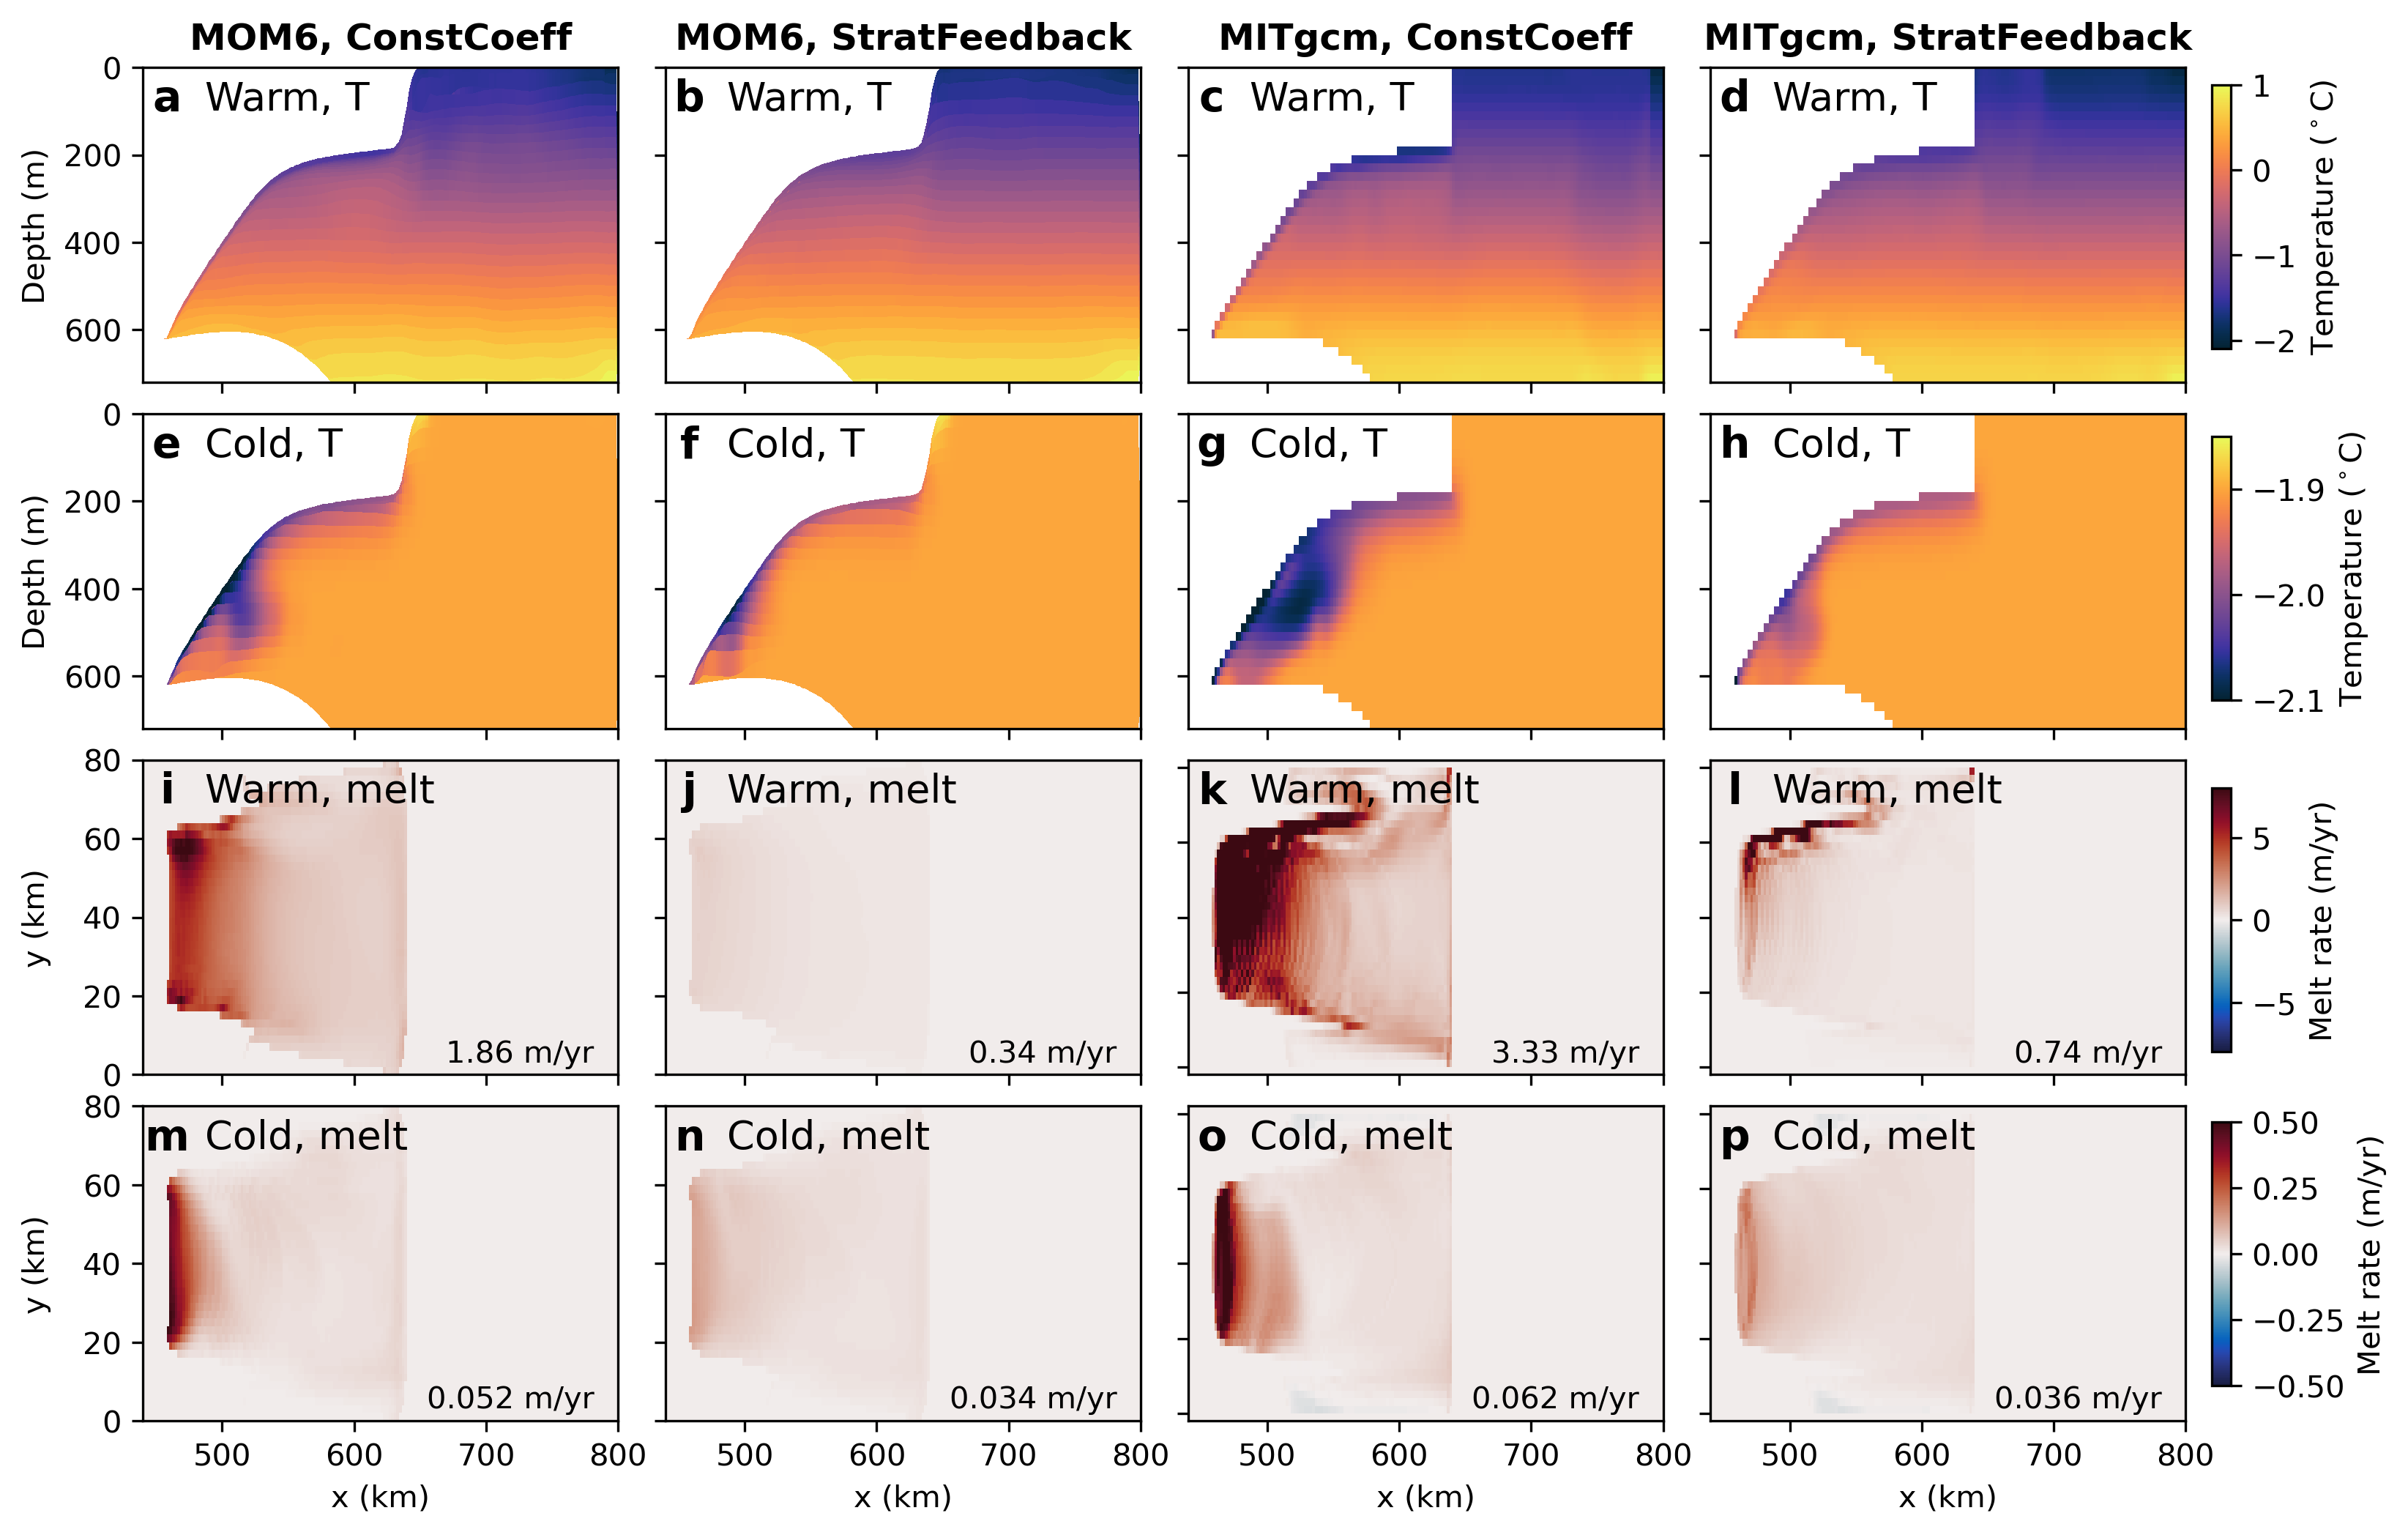

In [16]:
fig, axes = plt.subplots(nrows = 4, ncols = 4,figsize = (12,8),dpi = 300)

time = np.arange(-180,0)
y = 20
x = 20

plot_transect_MIT(axes[0,2], 0, y, 'Ttave', time, -2.1, 1, cm.cm.thermal)
plot_transect_MIT(axes[1,2], 2, y, 'Ttave', time, -2.1,-1.85, cm.cm.thermal)
pl, me = plot_melt_MIT(axes[2,2], 0, time, -8,8)
axes[2,2].text(0.95,0.02,f'{me:.2f}'+' m/yr',transform = axes[2,2].transAxes, ha = 'right',va = 'bottom')
pl, me = plot_melt_MIT(axes[3,2], 2, time, -0.5,0.5)
axes[3,2].text(0.95,0.02,f'{me:.3f}'+' m/yr',transform = axes[3,2].transAxes, ha = 'right',va = 'bottom')
# plot_rhooverturning_MIT(axes[4,2],0, -1, -1e-1,1e-1)
# plot_rhooverturning_MIT(axes[5,2],2, -1, -1e-2,1e-2)


plot_transect_MIT(axes[0,3], 1, y, 'Ttave', time, -2.1, 1, cm.cm.thermal)
plot_transect_MIT(axes[1,3], 3, y, 'Ttave', time, -2.1,-1.85, cm.cm.thermal)
pl, me = plot_melt_MIT(axes[2,3], 1, time, -8,8)
axes[2,3].text(0.95,0.02,f'{me:.2f}'+' m/yr',transform = axes[2,3].transAxes, ha = 'right',va = 'bottom')
pl, me = plot_melt_MIT(axes[3,3], 3, time, -0.5,0.5)
axes[3,3].text(0.95,0.02,f'{me:.3f}'+' m/yr',transform = axes[3,3].transAxes, ha = 'right',va = 'bottom')
# plot_rhooverturning_MIT(axes[4,3],1, -1, -1e-1,1e-1)
# plot_rhooverturning_MIT(axes[5,3],3, -1, -1e-2,1e-2)

prog, ocean_geometry = open_files_MOM6(0)
j = 0
wT = plot_MOM6(axes[0,0],x,time,j,prog.temp,"T ($^\circ$C)",-2.1,1,cm.cm.thermal)
wm,me = plot_melt_MOM6(axes[2,0],time,j,-8,8,cm.cm.balance)
axes[2,0].text(0.95,0.02,f'{me:.2f}'+' m/yr',transform = axes[2,0].transAxes, ha = 'right',va = 'bottom')
# plot_rhooverturning_MOM6(axes[4,0],j,-0.2,0.2,cm.cm.balance)

prog, ocean_geometry = open_files_MOM6(1)
j = 1
cT = plot_MOM6(axes[1,0],x,time,j,prog.temp,"T ($^\circ$C)",-2.1,-1.85,cm.cm.thermal)
wc,me = plot_melt_MOM6(axes[3,0],time,j,-0.5,0.5,cm.cm.balance)
axes[3,0].text(0.95,0.02,f'{me:.3f}'+' m/yr',transform = axes[3,0].transAxes, ha = 'right',va = 'bottom')
# plot_rhooverturning_MOM6(axes[5,0],j,-0.02,0.02,cm.cm.balance)


prog, ocean_geometry = open_files_MOM6(2)
j = 2
plot_MOM6(axes[0,1],x,time,j,prog.temp,"T ($^\circ$C)",-2.1,1,cm.cm.thermal)
pl, me = plot_melt_MOM6(axes[2,1],time,j,-8,8,cm.cm.balance)
axes[2,1].text(0.95,0.02,f'{me:.2f}'+' m/yr',transform = axes[2,1].transAxes, ha = 'right',va = 'bottom')
# plot_rhooverturning_MOM6(axes[4,1],j,-0.2,0.2,cm.cm.balance)

prog, ocean_geometry = open_files_MOM6(3)
j = 3
plot_MOM6(axes[1,1],x,time,j,prog.temp,"T ($^\circ$C)",-2.1,-1.85,cm.cm.thermal)
pl, me = plot_melt_MOM6(axes[3,1],time,j,-0.5,0.5,cm.cm.balance)
axes[3,1].text(0.95,0.02,f'{me:.3f}'+' m/yr',transform = axes[3,1].transAxes, ha = 'right',va = 'bottom')
# plot_rhooverturning_MOM6(axes[5,1],j,-0.02,0.02,cm.cm.balance)


caxwT = plt.axes([0.91,0.72,0.007,0.15])
plt.colorbar(wT, cax = caxwT, label = 'Temperature ($^\circ$C)')
caxcT = plt.axes([0.91,0.52,0.007,0.15])
plt.colorbar(cT, cax = caxcT, label = 'Temperature ($^\circ$C)')
caxwm = plt.axes([0.91,0.32,0.007,0.15])
plt.colorbar(wm, cax = caxwm, label = 'Melt rate (m/yr)')
caxcm = plt.axes([0.91,0.13,0.007,0.15])
plt.colorbar(wc, cax = caxcm, label = 'Melt rate (m/yr)')

fig.subplots_adjust(wspace = 0.1,hspace = 0.1)

axes[0,0].set_title('MOM6, ConstCoeff',fontweight='bold')# \n Warm, T')
axes[0,1].set_title('MOM6, StratFeedback',fontweight='bold')# \n Warm, T')
axes[0,2].set_title('MITgcm, ConstCoeff',fontweight='bold')# \n Warm, T')
axes[0,3].set_title('MITgcm, StratFeedback',fontweight='bold')# \n Warm, T')


for j in np.arange(1,4):
    for k in np.arange(4):
        axes[k,j].set_ylabel('')
        axes[k,j].yaxis.set_ticklabels([])
    # for k in np.arange(4,6):
    #     axes[k,j].yaxis.set_ticklabels([])

for j in np.arange(4):
    for k in np.arange(3):
        axes[k,j].set_xlabel('')
        axes[k,j].xaxis.set_ticklabels([])
        
for j in np.arange(4):
    axes[0,j].text(0.13,0.9,'Warm, T',horizontalalignment='left', # fontweight='bold',
             verticalalignment='center',transform=axes[0,j].transAxes, fontsize = 13)
    axes[1,j].text(0.13,0.9,'Cold, T',horizontalalignment='left', # fontweight='bold',
             verticalalignment='center',transform=axes[1,j].transAxes, fontsize = 13)
    axes[2,j].text(0.13,0.9,'Warm, melt',horizontalalignment='left', # fontweight='bold',
             verticalalignment='center',transform=axes[2,j].transAxes, fontsize = 13)
    axes[3,j].text(0.13,0.9,'Cold, melt',horizontalalignment='left', # fontweight='bold',
             verticalalignment='center',transform=axes[3,j].transAxes, fontsize = 13)

    for k in np.arange(4):
        if (k>0):
            axes[k,j].set_title('')
        alph = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o',
                'p','q']
        axes[k,j].set_xlim(440,800)
        axes[k,j].text(0.05,0.9,alph[k*4+j],horizontalalignment='center', fontweight='bold',
             verticalalignment='center',transform=axes[k,j].transAxes, fontsize = 14)
        
fig.align_ylabels([axes[0,0],axes[1,0],axes[2,0],axes[3,0]])
fig.align_ylabels([caxwT,caxcT,caxwm,caxcm])


Total Melt for layer-thermo-on-warm_CC experiment = 5400.8413 m/yr
Total Melt for layer-thermo-on-cold_CC experiment = 150.31348 m/yr
Total Melt for layer-thermo-on-warm_SF experiment = 989.15784 m/yr
Total Melt for layer-thermo-on-cold_SF experiment = 97.52208 m/yr


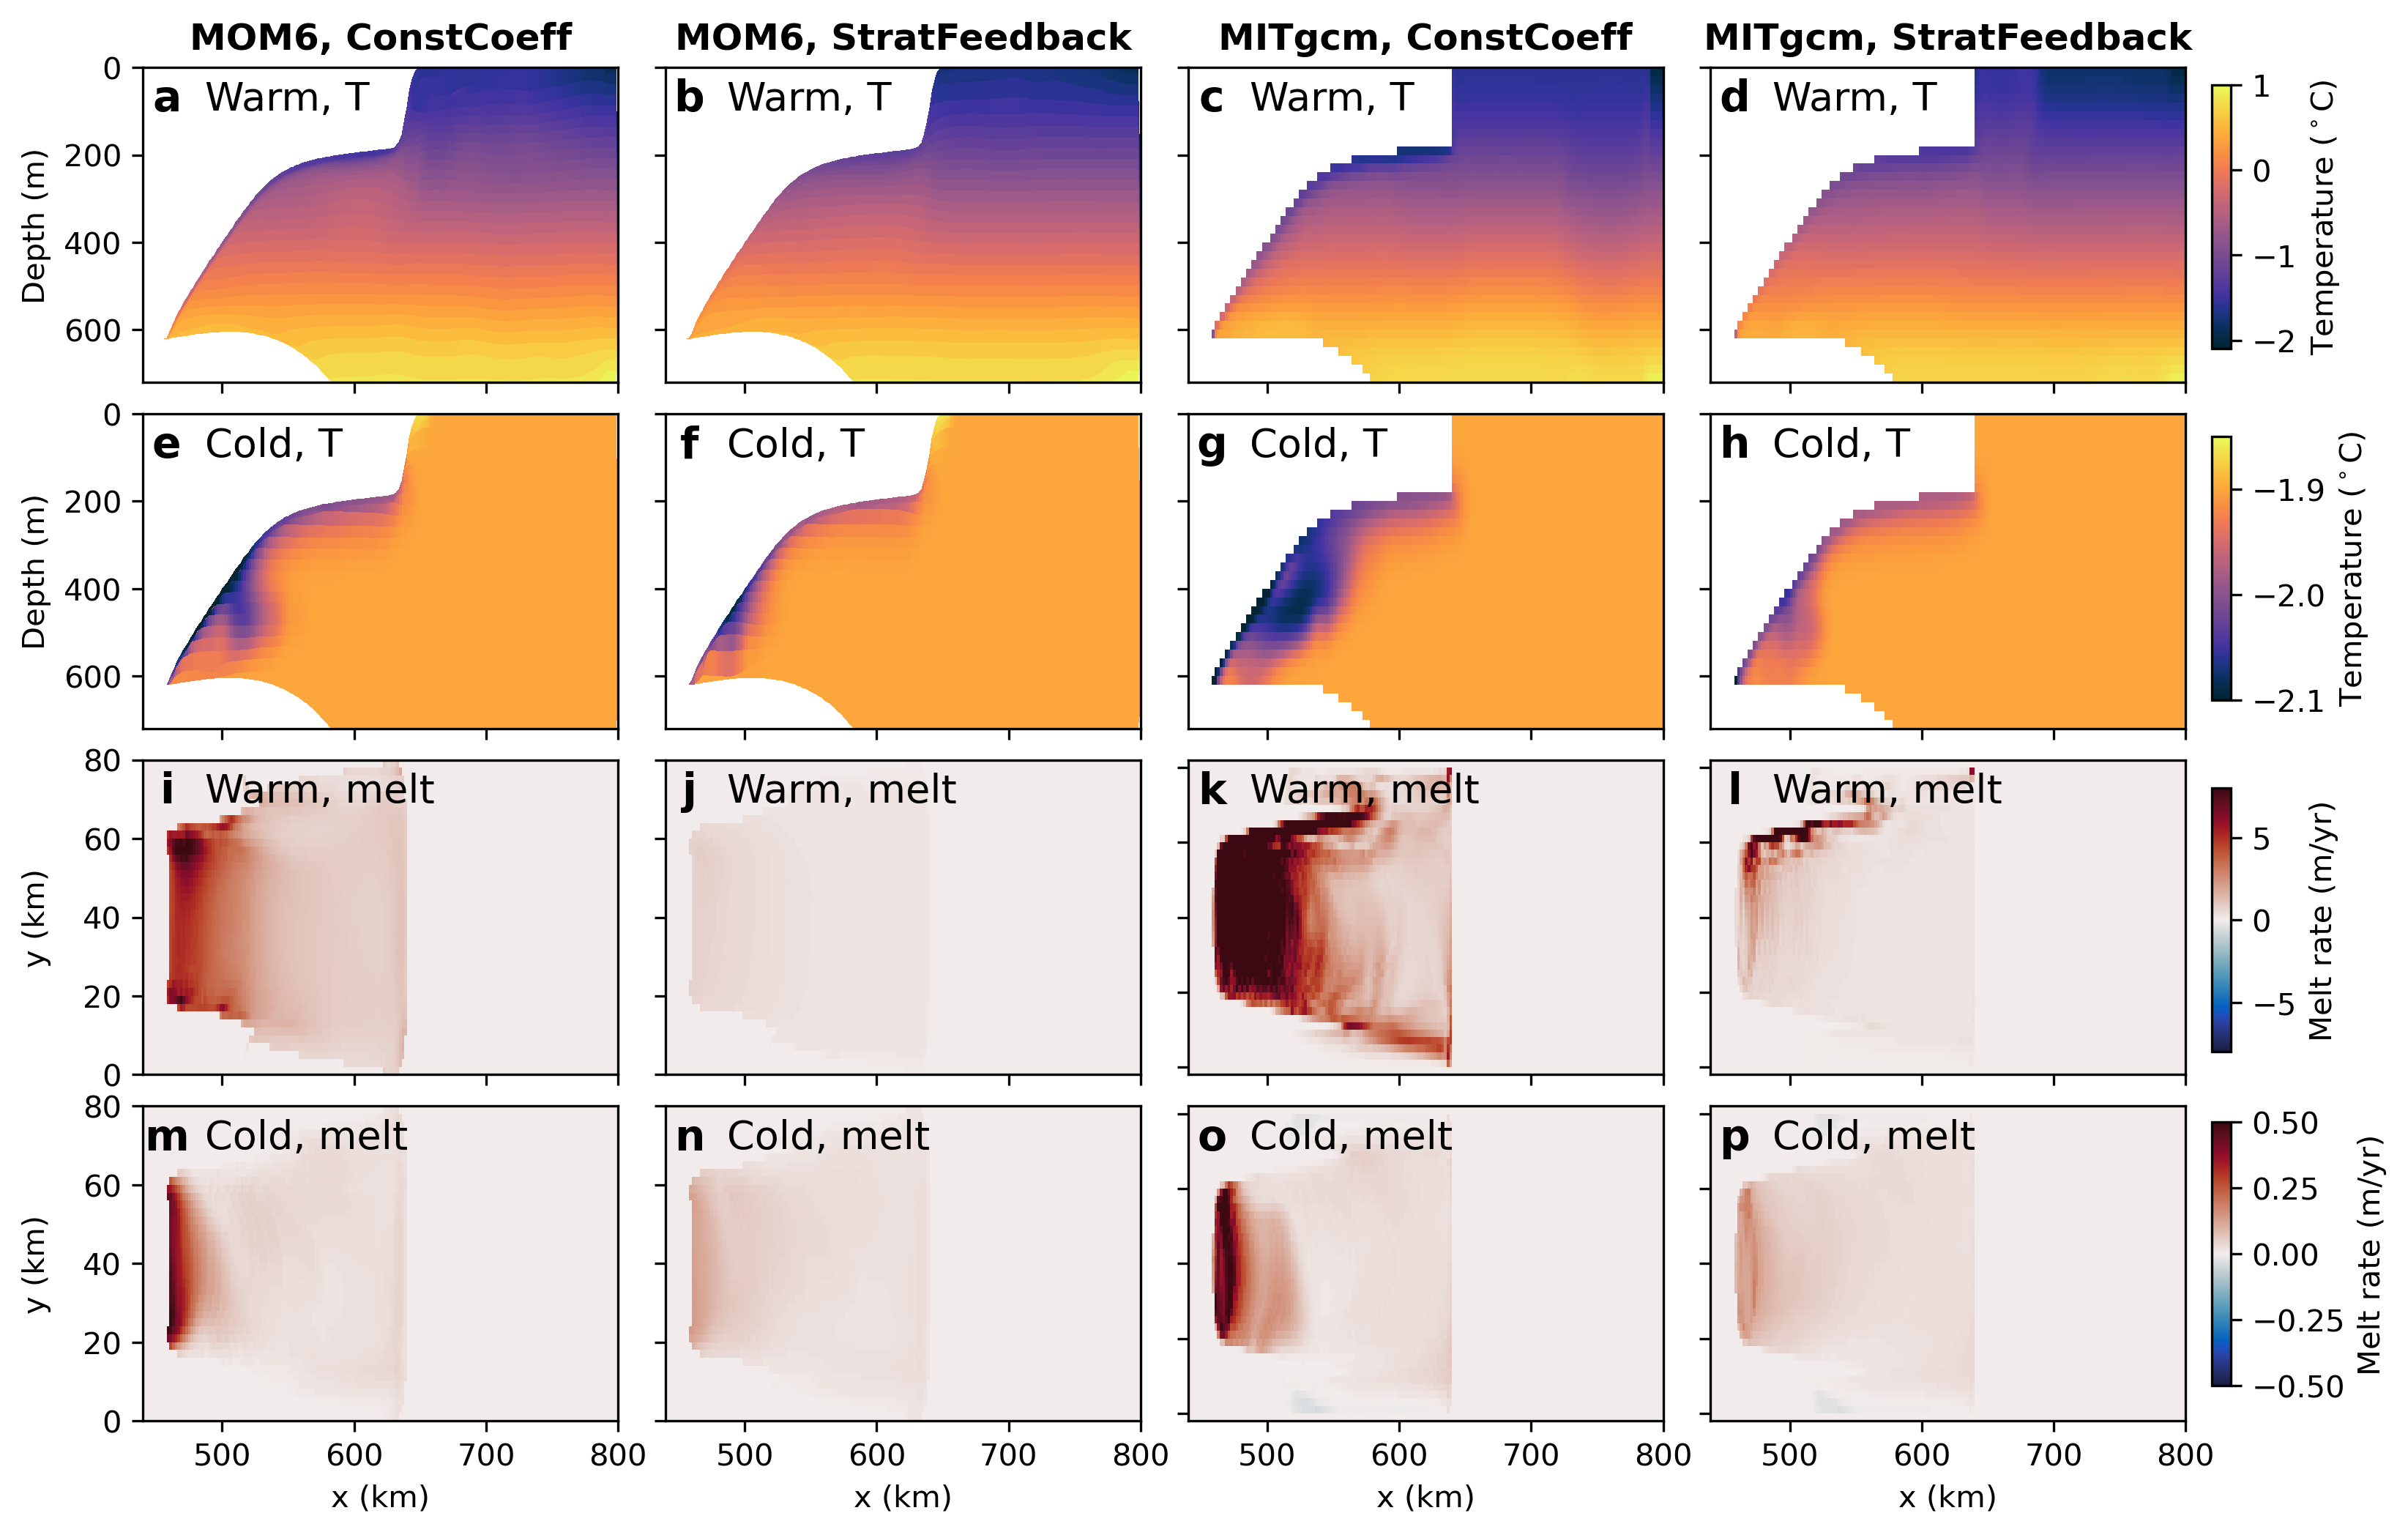

In [21]:
fig, axes = plt.subplots(nrows = 4, ncols = 4,figsize = (12,8),dpi = 300)

time = np.arange(-180,0)
y = 20
x = 20

plot_transect_MIT(axes[0,2], 0, y, 'Ttave', time, -2.1, 1, cm.cm.thermal)
plot_transect_MIT(axes[1,2], 2, y, 'Ttave', time, -2.1,-1.85, cm.cm.thermal)
plot_melt_MIT(axes[2,2], 0, time, -8,8)
plot_melt_MIT(axes[3,2], 2, time, -0.5,0.5)
# plot_rhooverturning_MIT(axes[4,2],0, -1, -1e-1,1e-1)
# plot_rhooverturning_MIT(axes[5,2],2, -1, -1e-2,1e-2)


plot_transect_MIT(axes[0,3], 1, y, 'Ttave', time, -2.1, 1, cm.cm.thermal)
plot_transect_MIT(axes[1,3], 3, y, 'Ttave', time, -2.1,-1.85, cm.cm.thermal)
plot_melt_MIT(axes[2,3], 1, time, -8,8)
plot_melt_MIT(axes[3,3], 3, time, -0.5,0.5)
# plot_rhooverturning_MIT(axes[4,3],1, -1, -1e-1,1e-1)
# plot_rhooverturning_MIT(axes[5,3],3, -1, -1e-2,1e-2)

prog, ocean_geometry = open_files_MOM6(0)
j = 0
wT = plot_MOM6(axes[0,0],x,time,j,prog.temp,"T ($^\circ$C)",-2.1,1,cm.cm.thermal)
wm = plot_melt_MOM6(axes[2,0],time,j,-8,8,cm.cm.balance)
# plot_rhooverturning_MOM6(axes[4,0],j,-0.2,0.2,cm.cm.balance)

prog, ocean_geometry = open_files_MOM6(1)
j = 1
cT = plot_MOM6(axes[1,0],x,time,j,prog.temp,"T ($^\circ$C)",-2.1,-1.85,cm.cm.thermal)
wc = plot_melt_MOM6(axes[3,0],time,j,-0.5,0.5,cm.cm.balance)
# plot_rhooverturning_MOM6(axes[5,0],j,-0.02,0.02,cm.cm.balance)


prog, ocean_geometry = open_files_MOM6(2)
j = 2
plot_MOM6(axes[0,1],x,time,j,prog.temp,"T ($^\circ$C)",-2.1,1,cm.cm.thermal)
plot_melt_MOM6(axes[2,1],time,j,-8,8,cm.cm.balance)
# plot_rhooverturning_MOM6(axes[4,1],j,-0.2,0.2,cm.cm.balance)

prog, ocean_geometry = open_files_MOM6(3)
j = 3
plot_MOM6(axes[1,1],x,time,j,prog.temp,"T ($^\circ$C)",-2.1,-1.85,cm.cm.thermal)
plot_melt_MOM6(axes[3,1],time,j,-0.5,0.5,cm.cm.balance)
# plot_rhooverturning_MOM6(axes[5,1],j,-0.02,0.02,cm.cm.balance)


caxwT = plt.axes([0.91,0.72,0.007,0.15])
plt.colorbar(wT, cax = caxwT, label = 'Temperature ($^\circ$C)')
caxcT = plt.axes([0.91,0.52,0.007,0.15])
plt.colorbar(cT, cax = caxcT, label = 'Temperature ($^\circ$C)')
caxwm = plt.axes([0.91,0.32,0.007,0.15])
plt.colorbar(wm, cax = caxwm, label = 'Melt rate (m/yr)')
caxcm = plt.axes([0.91,0.13,0.007,0.15])
plt.colorbar(wc, cax = caxcm, label = 'Melt rate (m/yr)')

fig.subplots_adjust(wspace = 0.1,hspace = 0.1)

axes[0,0].set_title('MOM6, ConstCoeff',fontweight='bold')# \n Warm, T')
axes[0,1].set_title('MOM6, StratFeedback',fontweight='bold')# \n Warm, T')
axes[0,2].set_title('MITgcm, ConstCoeff',fontweight='bold')# \n Warm, T')
axes[0,3].set_title('MITgcm, StratFeedback',fontweight='bold')# \n Warm, T')


for j in np.arange(1,4):
    for k in np.arange(4):
        axes[k,j].set_ylabel('')
        axes[k,j].yaxis.set_ticklabels([])
    # for k in np.arange(4,6):
    #     axes[k,j].yaxis.set_ticklabels([])

for j in np.arange(4):
    for k in np.arange(3):
        axes[k,j].set_xlabel('')
        axes[k,j].xaxis.set_ticklabels([])
        
for j in np.arange(4):
    axes[0,j].text(0.13,0.9,'Warm, T',horizontalalignment='left', # fontweight='bold',
             verticalalignment='center',transform=axes[0,j].transAxes, fontsize = 13)
    axes[1,j].text(0.13,0.9,'Cold, T',horizontalalignment='left', # fontweight='bold',
             verticalalignment='center',transform=axes[1,j].transAxes, fontsize = 13)
    axes[2,j].text(0.13,0.9,'Warm, melt',horizontalalignment='left', # fontweight='bold',
             verticalalignment='center',transform=axes[2,j].transAxes, fontsize = 13)
    axes[3,j].text(0.13,0.9,'Cold, melt',horizontalalignment='left', # fontweight='bold',
             verticalalignment='center',transform=axes[3,j].transAxes, fontsize = 13)

    for k in np.arange(4):
        if (k>0):
            axes[k,j].set_title('')
        alph = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o',
                'p','q']
        axes[k,j].set_xlim(440,800)
        axes[k,j].text(0.05,0.9,alph[k*4+j],horizontalalignment='center', fontweight='bold',
             verticalalignment='center',transform=axes[k,j].transAxes, fontsize = 14)
        
fig.align_ylabels([axes[0,0],axes[1,0],axes[2,0],axes[3,0]])
fig.align_ylabels([caxwT,caxcT,caxwm,caxcm])


(180, 42, 241, 50)
run-J10-warm-utide
Max Psi = 0.08571098876792435 Sv
(180, 42, 241, 50)
run-J10-cold-utide
Max Psi = 0.004903252798684502 Sv
(180, 42, 241, 50)
run-R22-warm-utide
Max Psi = 0.019678063287469103 Sv
(180, 42, 241, 50)
run-R22-cold-utide
Max Psi = 0.0034580380918827172 Sv
Total KE for layer-thermo-on-warm_CC experiment = 0.5512189499647755 m^2/s^2
Total KE for layer-thermo-on-cold_CC experiment = 0.019171930517942606 m^2/s^2
Total KE for layer-thermo-on-warm_SF experiment = 0.05763888580685391 m^2/s^2
Total KE for layer-thermo-on-cold_SF experiment = 0.019391081247002884 m^2/s^2
CPU times: user 50 s, sys: 43.6 s, total: 1min 33s
Wall time: 2min 3s


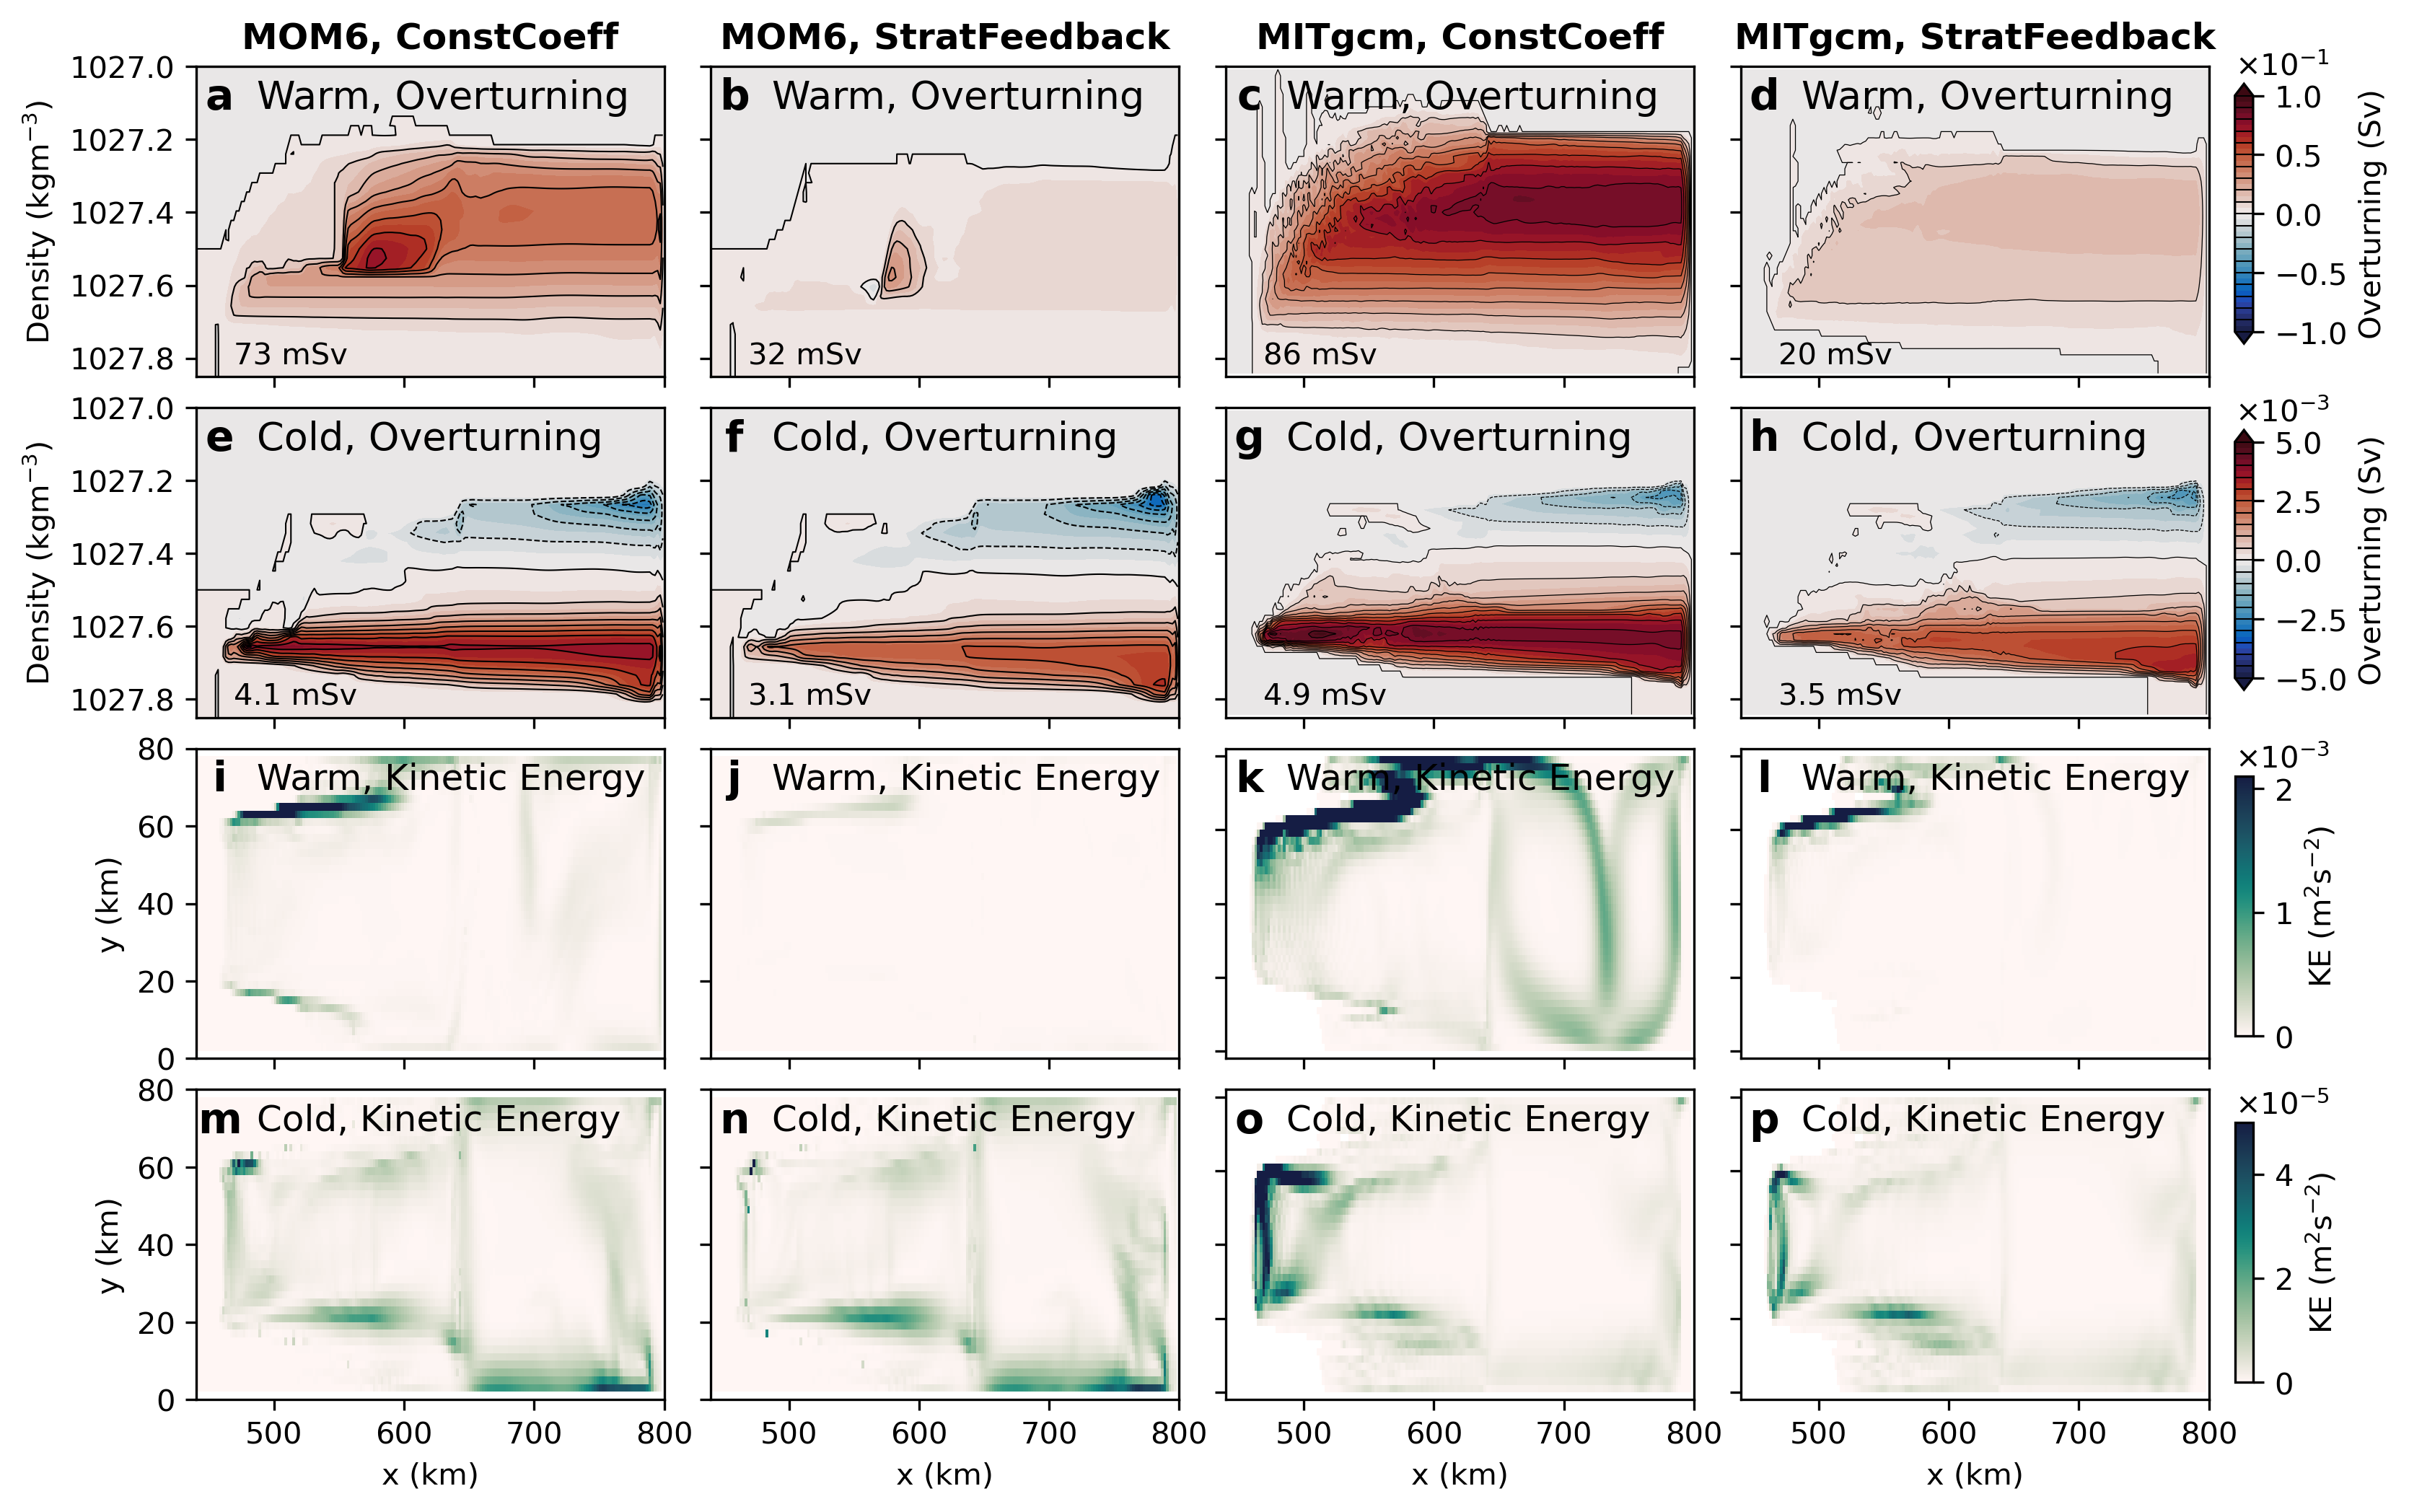

In [20]:
%%time

fig, axes = plt.subplots(nrows = 4, ncols = 4,figsize = (12,8),dpi = 300)

time = np.arange(-180,0)

c, osf0 = plot_rhooverturning_MIT(axes[0,2],0, time, -0.1,0.1)
c, osf2 = plot_rhooverturning_MIT(axes[1,2],2, time, -0.5e-2,0.5e-2)
plot_KE_MIT(axes[2,2], 0, time, 0,0.0021)
plot_KE_MIT(axes[3,2], 2, time, 0,0.00005)

axes[0,2].text(0.08,0.02,f'{osf0*1e3:.0f}'+' mSv',transform = axes[0,2].transAxes, ha = 'left',va = 'bottom')
axes[1,2].text(0.08,0.02,f'{osf2*1e3:.1f}'+' mSv',transform = axes[1,2].transAxes, ha = 'left',va = 'bottom')

c, osf1 = plot_rhooverturning_MIT(axes[0,3],1, time, -0.1,0.1)
c, osf3 = plot_rhooverturning_MIT(axes[1,3],3, time, -0.5e-2,0.5e-2)
plot_KE_MIT(axes[2,3], 1, time, 0,0.0021)
plot_KE_MIT(axes[3,3], 3, time, 0,0.00005)


axes[0,3].text(0.08,0.02,f'{osf1*1e3:.0f}'+' mSv',transform = axes[0,3].transAxes, ha = 'left',va = 'bottom')
axes[1,3].text(0.08,0.02,f'{osf3*1e3:.1f}'+' mSv',transform = axes[1,3].transAxes, ha = 'left',va = 'bottom')

time = np.arange(-6,0) #monthly

prog, ocean_geometry = open_files_MOM6(0)
j = 0
otw,otwl,osf0 = plot_rhooverturning_MOM6(axes[0,0],j,time,-0.1,0.1,cm.cm.balance)
kew = plot_KE_MOM6(axes[2,0],time,j,0,0.0021,cm.cm.tempo)
prog, ocean_geometry = open_files_MOM6(1)
j = 1
otc,otcl,osf1 = plot_rhooverturning_MOM6(axes[1,0],j,time,-0.5e-2,0.5e-2,cm.cm.balance)
kec  = plot_KE_MOM6(axes[3,0],time,j,0,0.00005,cm.cm.tempo)

axes[0,0].text(0.08,0.02,f'{osf0*1e3:.0f}'+' mSv',transform = axes[0,0].transAxes, ha = 'left',va = 'bottom')
axes[1,0].text(0.08,0.02,f'{osf1*1e3:.1f}'+' mSv',transform = axes[1,0].transAxes, ha = 'left',va = 'bottom')

prog, ocean_geometry = open_files_MOM6(2)
j = 2
c1,c2,osf2 = plot_rhooverturning_MOM6(axes[0,1],j,time,-0.1,0.1,cm.cm.balance)
plot_KE_MOM6(axes[2,1],time,j,0,0.0021,cm.cm.tempo)

prog, ocean_geometry = open_files_MOM6(3)
j = 3
c1,c2,osf3 = plot_rhooverturning_MOM6(axes[1,1],j,time,-0.5e-2,0.5e-2,cm.cm.balance)
plot_KE_MOM6(axes[3,1],time,j,0,0.00005,cm.cm.tempo)

axes[0,1].text(0.08,0.02,f'{osf2*1e3:.0f}'+' mSv',transform = axes[0,1].transAxes, ha = 'left',va = 'bottom')
axes[1,1].text(0.08,0.02,f'{osf3*1e3:.1f}'+' mSv',transform = axes[1,1].transAxes, ha = 'left',va = 'bottom')

caxwT = plt.axes([0.91,0.72,0.007,0.15])
cbar = plt.colorbar(otw, cax = caxwT, label = 'Overturning (Sv)')
cbar.add_lines(otwl)
cbar.set_ticks([-1e-1,-5e-2,0,5e-2,1e-1])
cbar.formatter.set_powerlimits((0, 0))
cbar.formatter.set_useMathText(True)
cbar.ax.yaxis.set_offset_position('left')
cbar.update_ticks()

caxcT = plt.axes([0.91,0.52,0.007,0.15])
cbar = plt.colorbar(otc, cax = caxcT, label = 'Overturning (Sv)')
cbar.add_lines(otcl)
cbar.set_ticks([-5e-3,-2.5e-3,0,2.5e-3,5e-3])
cbar.formatter.set_powerlimits((0, 0))
cbar.formatter.set_useMathText(True)
cbar.ax.yaxis.set_offset_position('left')
cbar.update_ticks()

caxwm = plt.axes([0.91,0.32,0.007,0.15])
cbar = plt.colorbar(kew, cax = caxwm, label = r'KE (m$^2$s$^{-2}$)')
cbar.formatter.set_powerlimits((0, 0))
cbar.formatter.set_useMathText(True)
cbar.ax.yaxis.set_offset_position('left')
cbar.update_ticks()

caxcm = plt.axes([0.91,0.12,0.007,0.15])
cbar = plt.colorbar(kec, cax = caxcm, label = r'KE (m$^2$s$^{-2}$)')
cbar.formatter.set_powerlimits((0, 0))
cbar.formatter.set_useMathText(True)
cbar.ax.yaxis.set_offset_position('left')
cbar.update_ticks()

fig.subplots_adjust(wspace = 0.1,hspace = 0.1)

axes[0,0].set_title('MOM6, ConstCoeff',fontweight='bold')# \n Warm, T')
axes[0,1].set_title('MOM6, StratFeedback',fontweight='bold')# \n Warm, T')
axes[0,2].set_title('MITgcm, ConstCoeff',fontweight='bold')# \n Warm, T')
axes[0,3].set_title('MITgcm, StratFeedback',fontweight='bold')# \n Warm, T')

for j in np.arange(4):
    axes[0,j].set_yticks([1027.8,1027.6,1027.4,1027.2,1027.0])
    axes[0,j].set_yticklabels(['1027.8','1027.6','1027.4','1027.2','1027.0'])    
    axes[1,j].set_yticks([1027.8,1027.6,1027.4,1027.2,1027.0])
    axes[1,j].set_yticklabels(['1027.8','1027.6','1027.4','1027.2','1027.0'])    

for j in np.arange(1,4):
    for k in np.arange(4):
        axes[k,j].set_ylabel('')
        axes[k,j].yaxis.set_ticklabels([])
    # for k in np.arange(4,6):
    #     axes[k,j].yaxis.set_ticklabels([])

for j in np.arange(4):
    for k in np.arange(3):
        axes[k,j].set_xlabel('')
        axes[k,j].xaxis.set_ticklabels([])
        
for j in np.arange(4):
    axes[0,j].text(0.13,0.9,'Warm, Overturning',horizontalalignment='left', # fontweight='bold',
             verticalalignment='center',transform=axes[0,j].transAxes, fontsize = 13)
    axes[1,j].text(0.13,0.9,'Cold, Overturning',horizontalalignment='left', # fontweight='bold',
             verticalalignment='center',transform=axes[1,j].transAxes, fontsize = 13)
    axes[2,j].text(0.13,0.9,'Warm, Kinetic Energy',horizontalalignment='left', # fontweight='bold',
             verticalalignment='center',transform=axes[2,j].transAxes, fontsize = 12)
    axes[3,j].text(0.13,0.9,'Cold, Kinetic Energy',horizontalalignment='left', # fontweight='bold',
             verticalalignment='center',transform=axes[3,j].transAxes, fontsize = 12)

    for k in np.arange(4):
        if (k>0):
            axes[k,j].set_title('')
        alph = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o',
                'p','q']
        axes[k,j].set_xlim(440,800)
        axes[k,j].text(0.05,0.9,alph[k*4+j],horizontalalignment='center', fontweight='bold',
             verticalalignment='center',transform=axes[k,j].transAxes, fontsize = 14)
        
#fig.align_ylabels([axes[0,0],axes[1,0],axes[2,0],axes[3,0]])



(180, 42, 241, 50)
run-J10-warm-utide
Max Psi = 0.09796385345964018 Sv
(180, 42, 241, 50)
run-J10-cold-utide
Max Psi = 0.004423017546707421 Sv
(180, 42, 241, 50)
run-R22-warm-utide
Max Psi = 0.01899906147555787 Sv
(180, 42, 241, 50)
run-R22-cold-utide
Max Psi = 0.003460218203403394 Sv
Total KE for layer-thermo-on-warm_CC experiment = 0.5512189499647755 m^2/s^2
Total KE for layer-thermo-on-cold_CC experiment = 0.019171930517942606 m^2/s^2
Total KE for layer-thermo-on-warm_SF experiment = 0.05763888580685391 m^2/s^2
Total KE for layer-thermo-on-cold_SF experiment = 0.019391081247002884 m^2/s^2
CPU times: user 34.3 s, sys: 28.7 s, total: 1min 3s
Wall time: 56.5 s


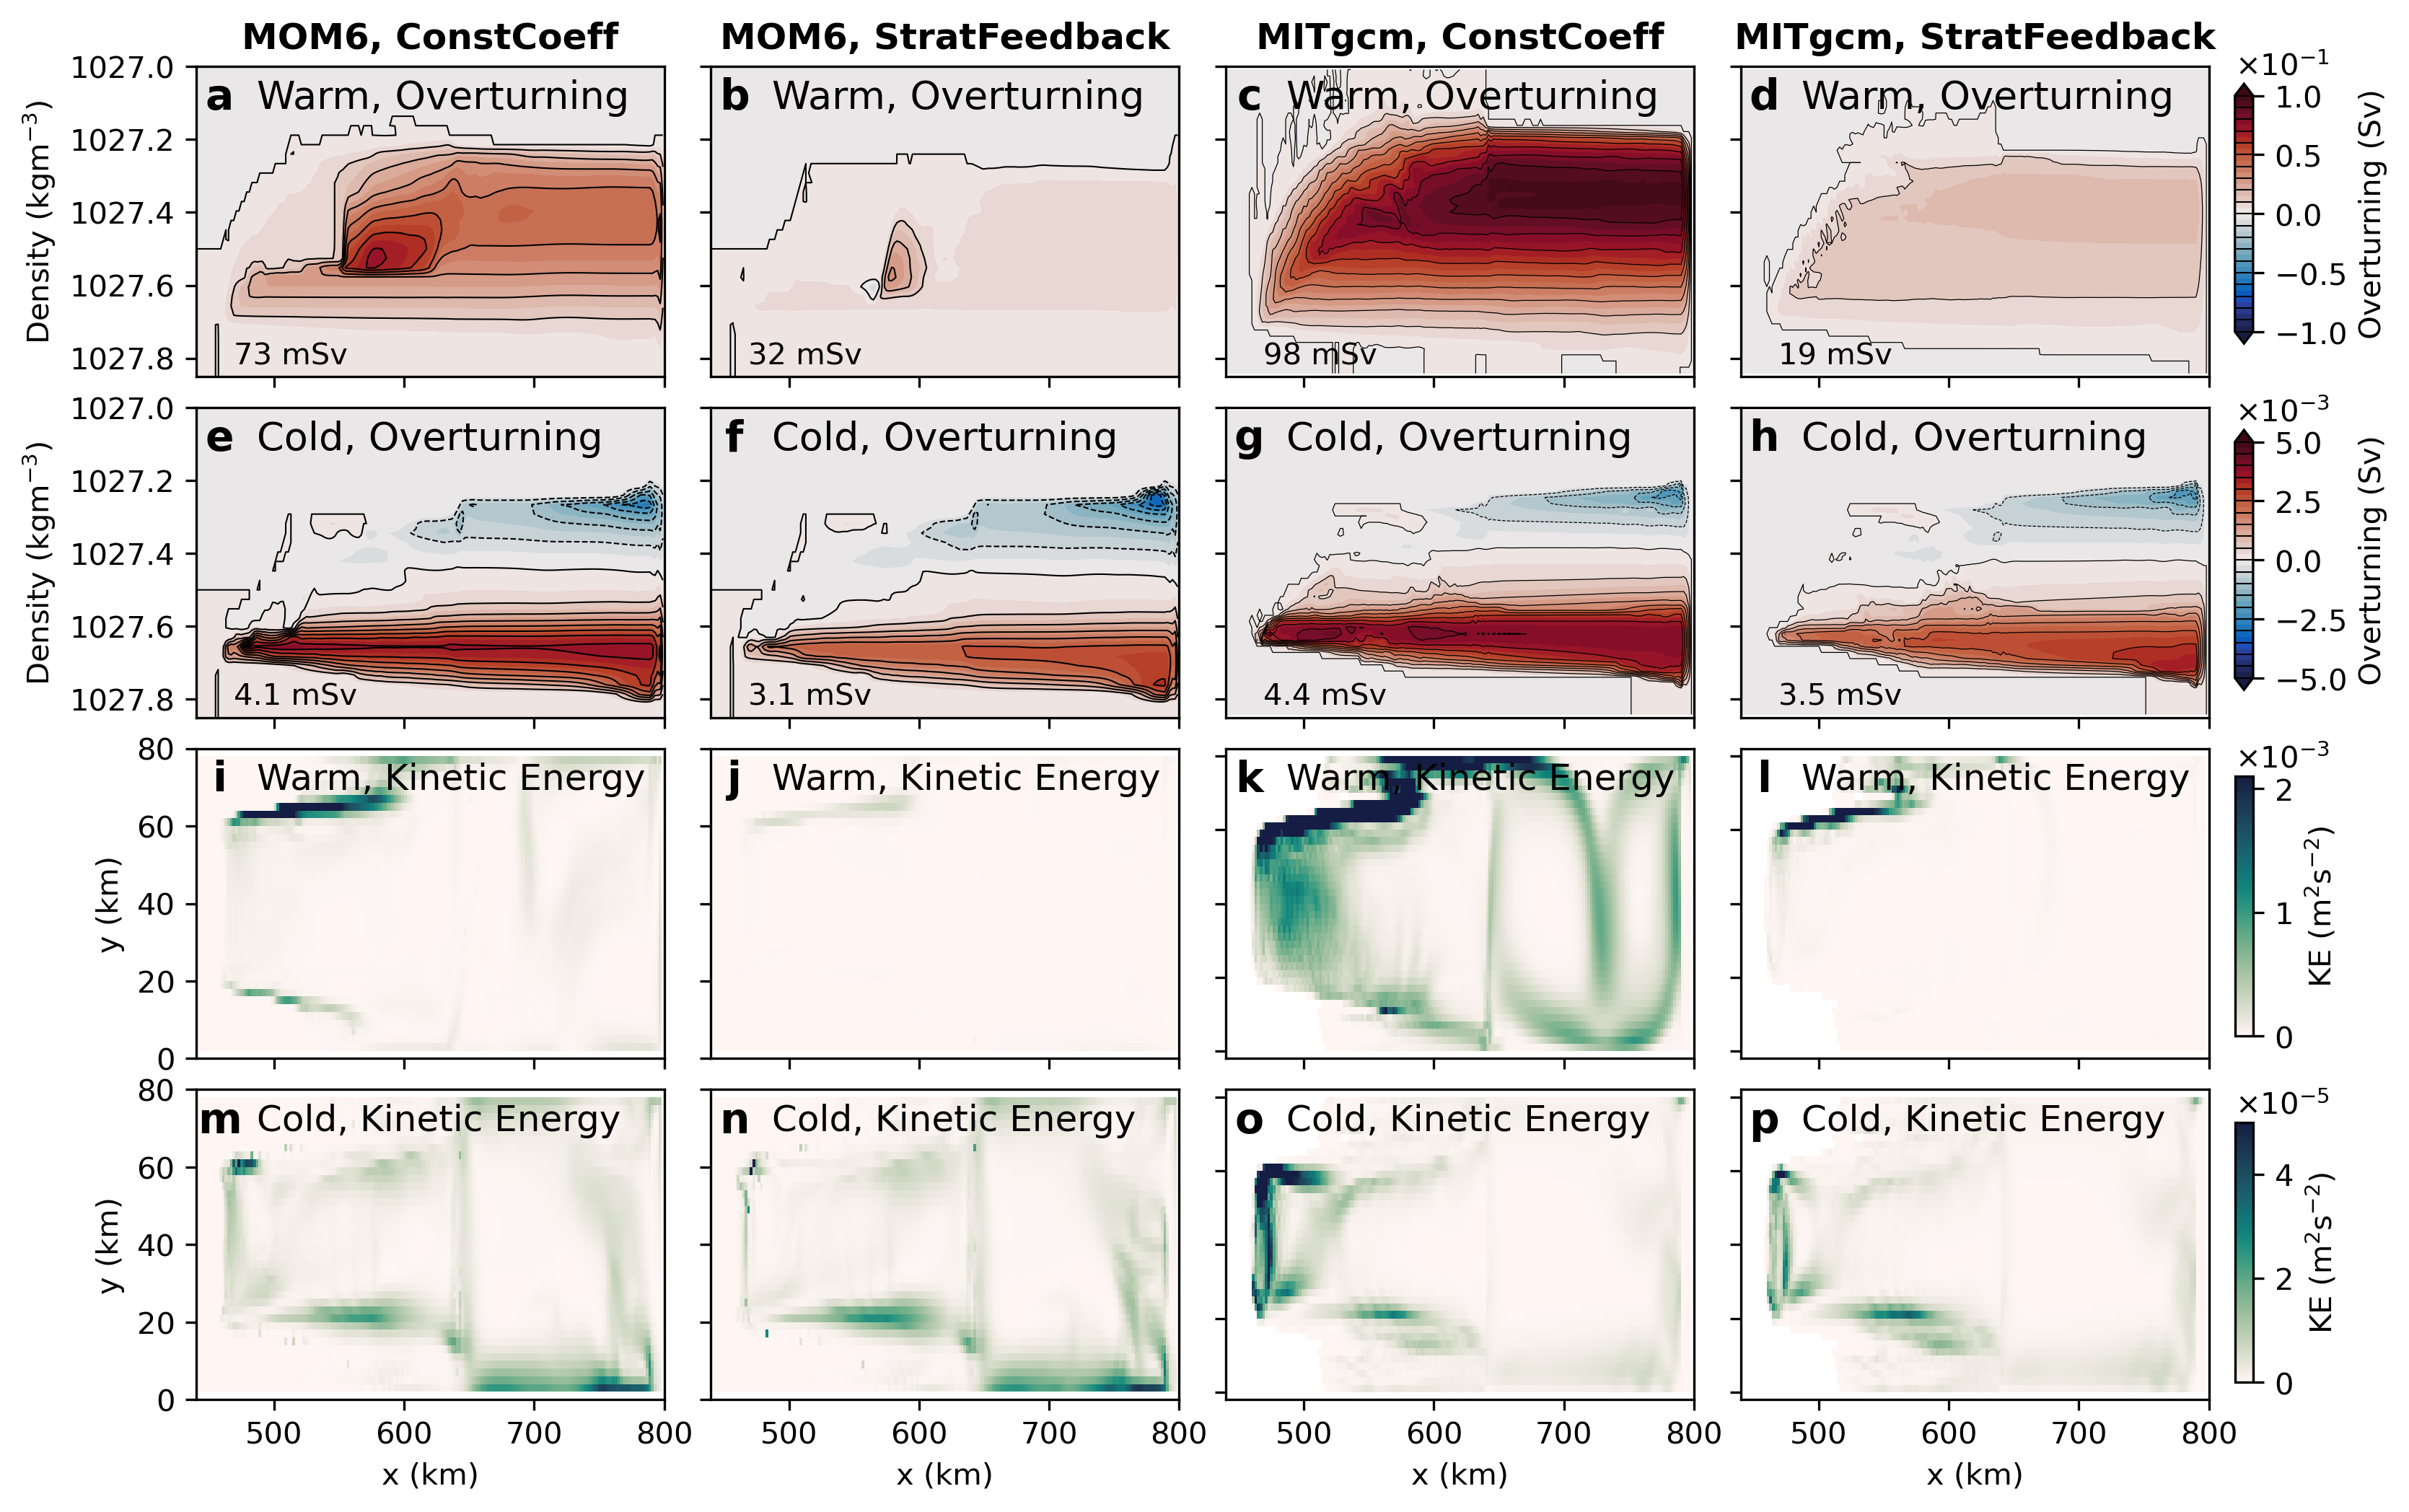

In [12]:
%%time

fig, axes = plt.subplots(nrows = 4, ncols = 4,figsize = (12,8),dpi = 300)

time = np.arange(-180,0)

c, osf0 = plot_rhooverturning_MIT(axes[0,2],0, time, -0.1,0.1)
c, osf2 = plot_rhooverturning_MIT(axes[1,2],2, time, -0.5e-2,0.5e-2)
plot_KE_MIT(axes[2,2], 0, time, 0,0.0021)
plot_KE_MIT(axes[3,2], 2, time, 0,0.00005)

axes[0,2].text(0.08,0.02,f'{osf0*1e3:.0f}'+' mSv',transform = axes[0,2].transAxes, ha = 'left',va = 'bottom')
axes[1,2].text(0.08,0.02,f'{osf2*1e3:.1f}'+' mSv',transform = axes[1,2].transAxes, ha = 'left',va = 'bottom')

c, osf1 = plot_rhooverturning_MIT(axes[0,3],1, time, -0.1,0.1)
c, osf3 = plot_rhooverturning_MIT(axes[1,3],3, time, -0.5e-2,0.5e-2)
plot_KE_MIT(axes[2,3], 1, time, 0,0.0021)
plot_KE_MIT(axes[3,3], 3, time, 0,0.00005)


axes[0,3].text(0.08,0.02,f'{osf1*1e3:.0f}'+' mSv',transform = axes[0,3].transAxes, ha = 'left',va = 'bottom')
axes[1,3].text(0.08,0.02,f'{osf3*1e3:.1f}'+' mSv',transform = axes[1,3].transAxes, ha = 'left',va = 'bottom')

time = np.arange(-6,0) #monthly

prog, ocean_geometry = open_files_MOM6(0)
j = 0
otw,otwl,osf0 = plot_rhooverturning_MOM6(axes[0,0],j,time,-0.1,0.1,cm.cm.balance)
kew = plot_KE_MOM6(axes[2,0],time,j,0,0.0021,cm.cm.tempo)
prog, ocean_geometry = open_files_MOM6(1)
j = 1
otc,otcl,osf1 = plot_rhooverturning_MOM6(axes[1,0],j,time,-0.5e-2,0.5e-2,cm.cm.balance)
kec  = plot_KE_MOM6(axes[3,0],time,j,0,0.00005,cm.cm.tempo)

axes[0,0].text(0.08,0.02,f'{osf0*1e3:.0f}'+' mSv',transform = axes[0,0].transAxes, ha = 'left',va = 'bottom')
axes[1,0].text(0.08,0.02,f'{osf1*1e3:.1f}'+' mSv',transform = axes[1,0].transAxes, ha = 'left',va = 'bottom')

prog, ocean_geometry = open_files_MOM6(2)
j = 2
c1,c2,osf2 = plot_rhooverturning_MOM6(axes[0,1],j,time,-0.1,0.1,cm.cm.balance)
plot_KE_MOM6(axes[2,1],time,j,0,0.0021,cm.cm.tempo)

prog, ocean_geometry = open_files_MOM6(3)
j = 3
c1,c2,osf3 = plot_rhooverturning_MOM6(axes[1,1],j,time,-0.5e-2,0.5e-2,cm.cm.balance)
plot_KE_MOM6(axes[3,1],time,j,0,0.00005,cm.cm.tempo)

axes[0,1].text(0.08,0.02,f'{osf2*1e3:.0f}'+' mSv',transform = axes[0,1].transAxes, ha = 'left',va = 'bottom')
axes[1,1].text(0.08,0.02,f'{osf3*1e3:.1f}'+' mSv',transform = axes[1,1].transAxes, ha = 'left',va = 'bottom')

caxwT = plt.axes([0.91,0.72,0.007,0.15])
cbar = plt.colorbar(otw, cax = caxwT, label = 'Overturning (Sv)')
cbar.add_lines(otwl)
cbar.set_ticks([-1e-1,-5e-2,0,5e-2,1e-1])
cbar.formatter.set_powerlimits((0, 0))
cbar.formatter.set_useMathText(True)
cbar.ax.yaxis.set_offset_position('left')
cbar.update_ticks()

caxcT = plt.axes([0.91,0.52,0.007,0.15])
cbar = plt.colorbar(otc, cax = caxcT, label = 'Overturning (Sv)')
cbar.add_lines(otcl)
cbar.set_ticks([-5e-3,-2.5e-3,0,2.5e-3,5e-3])
cbar.formatter.set_powerlimits((0, 0))
cbar.formatter.set_useMathText(True)
cbar.ax.yaxis.set_offset_position('left')
cbar.update_ticks()

caxwm = plt.axes([0.91,0.32,0.007,0.15])
cbar = plt.colorbar(kew, cax = caxwm, label = r'KE (m$^2$s$^{-2}$)')
cbar.formatter.set_powerlimits((0, 0))
cbar.formatter.set_useMathText(True)
cbar.ax.yaxis.set_offset_position('left')
cbar.update_ticks()

caxcm = plt.axes([0.91,0.12,0.007,0.15])
cbar = plt.colorbar(kec, cax = caxcm, label = r'KE (m$^2$s$^{-2}$)')
cbar.formatter.set_powerlimits((0, 0))
cbar.formatter.set_useMathText(True)
cbar.ax.yaxis.set_offset_position('left')
cbar.update_ticks()

fig.subplots_adjust(wspace = 0.1,hspace = 0.1)

axes[0,0].set_title('MOM6, ConstCoeff',fontweight='bold')# \n Warm, T')
axes[0,1].set_title('MOM6, StratFeedback',fontweight='bold')# \n Warm, T')
axes[0,2].set_title('MITgcm, ConstCoeff',fontweight='bold')# \n Warm, T')
axes[0,3].set_title('MITgcm, StratFeedback',fontweight='bold')# \n Warm, T')

for j in np.arange(4):
    axes[0,j].set_yticks([1027.8,1027.6,1027.4,1027.2,1027.0])
    axes[0,j].set_yticklabels(['1027.8','1027.6','1027.4','1027.2','1027.0'])    
    axes[1,j].set_yticks([1027.8,1027.6,1027.4,1027.2,1027.0])
    axes[1,j].set_yticklabels(['1027.8','1027.6','1027.4','1027.2','1027.0'])    

for j in np.arange(1,4):
    for k in np.arange(4):
        axes[k,j].set_ylabel('')
        axes[k,j].yaxis.set_ticklabels([])
    # for k in np.arange(4,6):
    #     axes[k,j].yaxis.set_ticklabels([])

for j in np.arange(4):
    for k in np.arange(3):
        axes[k,j].set_xlabel('')
        axes[k,j].xaxis.set_ticklabels([])
        
for j in np.arange(4):
    axes[0,j].text(0.13,0.9,'Warm, Overturning',horizontalalignment='left', # fontweight='bold',
             verticalalignment='center',transform=axes[0,j].transAxes, fontsize = 13)
    axes[1,j].text(0.13,0.9,'Cold, Overturning',horizontalalignment='left', # fontweight='bold',
             verticalalignment='center',transform=axes[1,j].transAxes, fontsize = 13)
    axes[2,j].text(0.13,0.9,'Warm, Kinetic Energy',horizontalalignment='left', # fontweight='bold',
             verticalalignment='center',transform=axes[2,j].transAxes, fontsize = 12)
    axes[3,j].text(0.13,0.9,'Cold, Kinetic Energy',horizontalalignment='left', # fontweight='bold',
             verticalalignment='center',transform=axes[3,j].transAxes, fontsize = 12)

    for k in np.arange(4):
        if (k>0):
            axes[k,j].set_title('')
        alph = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o',
                'p','q']
        axes[k,j].set_xlim(440,800)
        axes[k,j].text(0.05,0.9,alph[k*4+j],horizontalalignment='center', fontweight='bold',
             verticalalignment='center',transform=axes[k,j].transAxes, fontsize = 14)
        
#fig.align_ylabels([axes[0,0],axes[1,0],axes[2,0],axes[3,0]])



In [13]:
osf

array(0.00387276)

In [14]:
ke

array(2.28816603e-06)

# Plot Lplus

In [29]:
def plot_Lplus(ax,time_slice,i,vmin1,vmax1,cmap):
    ocean_daily_z = xr.open_dataset('/home/156/cy8964/mom6-control/isomip-control/ISOMIP-MOM6-examples/'+list_folders_MOM6[i]+'/archive/output000/ocean_daily_z.nc')
    file_name = list_folders_MOM6[i]
    print(file_name)
    label = list_folders_MOM6[i]
    s_to_year = 3600*24*365
    dataplot = ocean_daily_z.lplus.isel(time = time_slice).mean('time')#/1030/(2000)**2*s_to_year
    
    p1 = dataplot.plot.contourf(ax = ax, cmap = cmap, levels = [0,2500,1e4], extend = 'both',add_colorbar = False)
    # plt.colorbar(p1, ax = ax, label = '$\log_{10}L^+$')
    # if (np.max(np.log10(dataplot).values)>np.log10(1e4)):
    #     np.log10(dataplot).plot.contourf(ax = ax, levels = [0,np.log10(2500),np.log10(1e4)],colors='none', hatches=['...','xxx', None], add_colorbar = False)
    # else:
    #     np.log10(dataplot).plot.contourf(ax = ax, levels = [0,np.log10(2500)],colors='none', hatches=['...', None], add_colorbar = False)
        
    ax.set_ylabel('y (km)', fontsize = 13)
    ax.set_xlabel('x (km)', fontsize = 13)
    ax.set_title('$L^+$ , ' +label)

    return p1


In [30]:
list_folders_MOM6

['layer-thermo-on-warm_CC-u02tides',
 'layer-thermo-on-cold_CC-u02tides',
 'layer-thermo-on-warm_SF-u02tides',
 'layer-thermo-on-cold_SF-u02tides']

In [31]:
len(suffixes)

6

['layer-thermo-on-warm_CC' 'layer-thermo-on-cold_CC'
 'layer-thermo-on-warm_SF' 'layer-thermo-on-cold_SF'
 'layer-thermo-on-warm_CC-ustarmin' 'layer-thermo-on-cold_CC-ustarmin'
 'layer-thermo-on-warm_SF-ustarmin' 'layer-thermo-on-cold_SF-ustarmin'
 'layer-thermo-on-warm_CC-u01tides' 'layer-thermo-on-cold_CC-u01tides'
 'layer-thermo-on-warm_SF-u01tides' 'layer-thermo-on-cold_SF-u01tides'
 'layer-thermo-on-warm_CC-u005tides' 'layer-thermo-on-cold_CC-u005tides'
 'layer-thermo-on-warm_SF-u005tides' 'layer-thermo-on-cold_SF-u005tides'
 'layer-thermo-on-warm_CC-u001tides' 'layer-thermo-on-cold_CC-u001tides'
 'layer-thermo-on-warm_SF-u001tides' 'layer-thermo-on-cold_SF-u001tides'
 'layer-thermo-on-warm_CC-u02tides' 'layer-thermo-on-cold_CC-u02tides'
 'layer-thermo-on-warm_SF-u02tides' 'layer-thermo-on-cold_SF-u02tides']
layer-thermo-on-warm_SF
layer-thermo-on-cold_SF
layer-thermo-on-warm_SF-ustarmin
layer-thermo-on-cold_SF-ustarmin
layer-thermo-on-warm_SF-u005tides
layer-thermo-on-cold_SF-u00

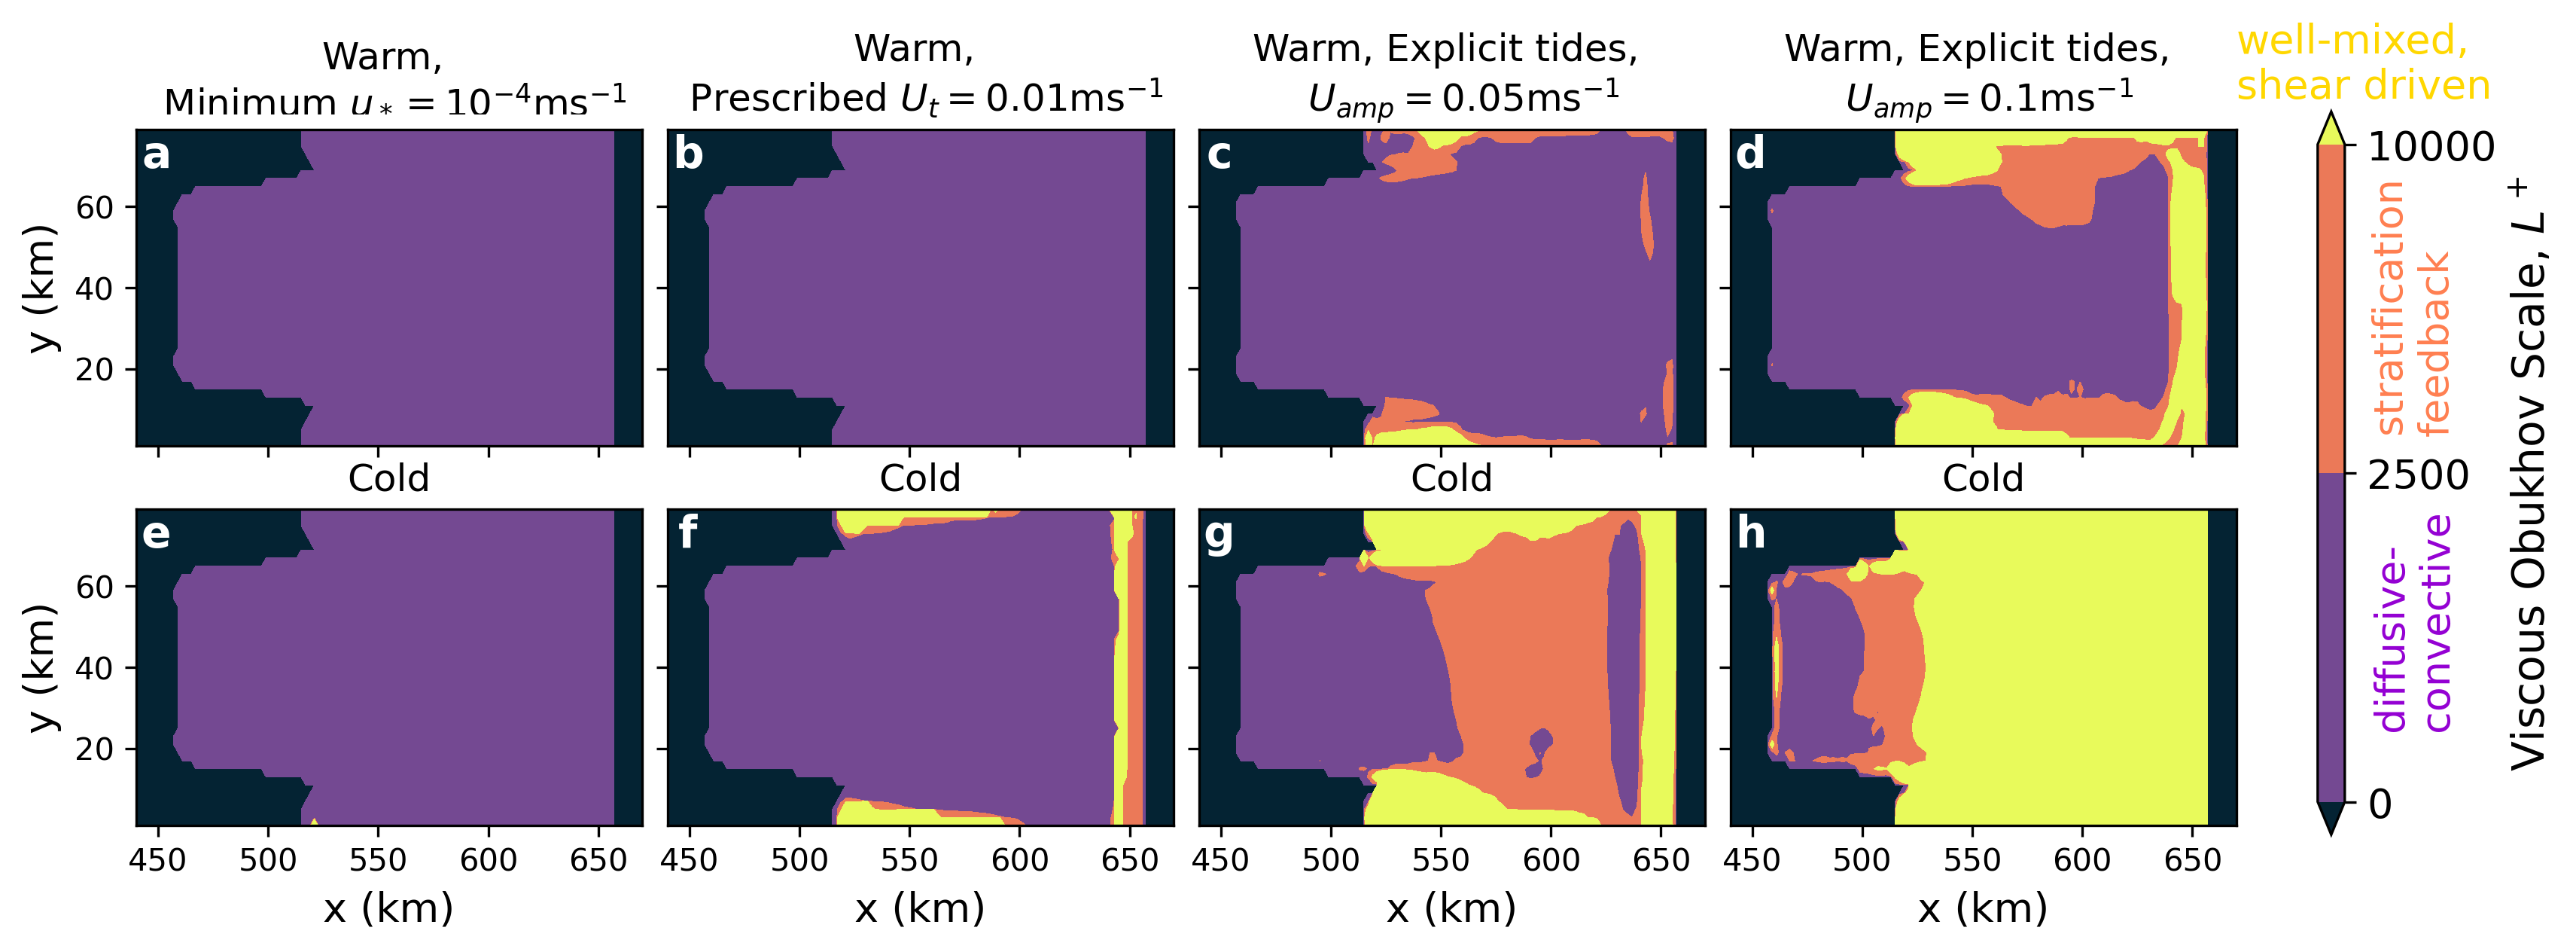

In [40]:
# list_folders_MOM6 = [
#                 'layer-thermo-on-warm_R22limexdiags', 'layer-thermo-on-cold_R22limexdiags',
#                 'layer-thermo-on-warm_R22newexdiags', 'layer-thermo-on-cold_R22newexdiags',
#                 'layer-thermo-on-warm_R22limexdiags-utide0', 'layer-thermo-on-cold_R22limexdiags-utide0',
#                 'layer-thermo-on-warm_R22newexdiags-utide0', 'layer-thermo-on-cold_R22newexdiags-utide0',
#                 'layer-thermo-on-warm_R22limexdiags-u01tides', 'layer-thermo-on-cold_R22limexdiags-u01tides',
#                 'layer-thermo-on-warm_R22newexdiags-u01tides', 'layer-thermo-on-cold_R22newexdiags-u01tides',
#                 'layer-thermo-on-warm_R22limexdiags-u005tides', 'layer-thermo-on-cold_R22limexdiags-u005tides',
#                 'layer-thermo-on-warm_R22newexdiags-u005tides', 'layer-thermo-on-cold_R22newexdiags-u005tides',
#                 'layer-thermo-on-warm_R22limexdiags-u001tides', 'layer-thermo-on-cold_R22limexdiags-u001tides',
#                 'layer-thermo-on-warm_R22newexdiags-u001tides', 'layer-thermo-on-cold_R22newexdiags-u001tides',
# ]    
list_folders_base = ['layer-thermo-on-warm_CC','layer-thermo-on-cold_CC',
               'layer-thermo-on-warm_SF','layer-thermo-on-cold_SF']
suffixes = ['','-ustarmin','-u01tides','-u005tides','-u001tides','-u02tides']#,'-convectivelimitlocal']
list_folders = []
for n in np.arange(len(suffixes)):
    list_folders = np.append(list_folders, [x+suffixes[n] for x in list_folders_base])
print(list_folders)
list_folders_MOM6 = list_folders
fig, axes = plt.subplots(nrows = 2, ncols = 4,figsize = (12,4),dpi = 300)

time = np.arange(-180,0)
y = 20
x = 20


plot_Lplus(axes[0,1],time,2,0,4,cm.cm.thermal)
axes[0,1].set_title('Warm, \n Prescribed $U_t = 0.01$ms$^{-1}$')
plot_Lplus(axes[1,1],time,3,0,4,cm.cm.thermal)
axes[1,1].set_title('Cold')

plot_Lplus(axes[0,0],time,6,0,4,cm.cm.thermal)
axes[0,0].set_title('Warm, \n Minimum $u_* = 10^{-4}$ms$^{-1}$')
plot_Lplus(axes[1,0],time,7,0,4,cm.cm.thermal)
axes[1,0].set_title('Cold')

plot_Lplus(axes[0,2],time,14,0,4,cm.cm.thermal)
axes[0,2].set_title('Warm, Explicit tides, \n '+r' $U_{amp} = 0.05$ms$^{-1}$')
plot_Lplus(axes[1,2],time,15,0,4,cm.cm.thermal)
axes[1,2].set_title('Cold')

plot_Lplus(axes[0,3],time,10,0,4,cm.cm.thermal)
axes[0,3].set_title('Warm, Explicit tides, \n '+ r'$U_{amp} = 0.1$ms$^{-1}$')
p1 = plot_Lplus(axes[1,3],time,11,0,4,cm.cm.thermal)
axes[1,3].set_title('Cold')

cax = plt.axes([0.93,0.1,0.01,0.8])
cb = plt.colorbar(p1, cax = cax).set_label(size = 14, label = 'Viscous Obukhov Scale, $L^+$')

for j in np.arange(4):
    for k in np.arange(2):
        axes[k,j].set_xlim(440,670)

for j in np.arange(1,4):
    for k in np.arange(2):
        axes[k,j].set_ylabel('')
        axes[k,j].set_yticklabels('')

for j in np.arange(4):
    axes[0,j].set_xlabel('')
    axes[0,j].set_xticklabels('')
plt.tick_params(labelsize=13)
#plt.text(

plt.text(2,0.12, 'diffusive-\nconvective',rotation = 90,
        transform=cax.transAxes,color = 'darkviolet',fontsize = 13)
plt.text(2,0.57, 'stratification \nfeedback',rotation = 90,
        transform=cax.transAxes,color = 'coral',fontsize = 13)
plt.text(-3,1.07, 'well-mixed,\nshear driven',#rotation = 90
        transform=cax.transAxes,color = 'gold',fontsize = 13)

axes[0,0].text(0.04,0.92,'a',horizontalalignment='center', fontweight='bold',
     verticalalignment='center',transform=axes[0,0].transAxes, fontsize = 14,color = 'w')
axes[0,1].text(0.04,0.92,'b',horizontalalignment='center', fontweight='bold',
     verticalalignment='center',transform=axes[0,1].transAxes, fontsize = 14,color = 'w')
axes[0,2].text(0.04,0.92,'c',horizontalalignment='center', fontweight='bold',
     verticalalignment='center',transform=axes[0,2].transAxes, fontsize = 14,color = 'w')
axes[0,3].text(0.04,0.92,'d',horizontalalignment='center', fontweight='bold',
     verticalalignment='center',transform=axes[0,3].transAxes, fontsize = 14,color = 'w')
axes[1,0].text(0.04,0.92,'e',horizontalalignment='center', fontweight='bold',
     verticalalignment='center',transform=axes[1,0].transAxes, fontsize = 14,color = 'w')
axes[1,1].text(0.04,0.92,'f',horizontalalignment='center', fontweight='bold',
     verticalalignment='center',transform=axes[1,1].transAxes, fontsize = 14,color = 'w')
axes[1,2].text(0.04,0.92,'g',horizontalalignment='center', fontweight='bold',
     verticalalignment='center',transform=axes[1,2].transAxes, fontsize = 14,color = 'w')
axes[1,3].text(0.04,0.92,'h',horizontalalignment='center', fontweight='bold',
     verticalalignment='center',transform=axes[1,3].transAxes, fontsize = 14,color = 'w')


fig.subplots_adjust(hspace = 0.2,wspace = 0.05)

['layer-thermo-on-warm_CC' 'layer-thermo-on-cold_CC'
 'layer-thermo-on-warm_SF' 'layer-thermo-on-cold_SF'
 'layer-thermo-on-warm_CC-ustarmin' 'layer-thermo-on-cold_CC-ustarmin'
 'layer-thermo-on-warm_SF-ustarmin' 'layer-thermo-on-cold_SF-ustarmin'
 'layer-thermo-on-warm_CC-u005tides' 'layer-thermo-on-cold_CC-u005tides'
 'layer-thermo-on-warm_SF-u005tides' 'layer-thermo-on-cold_SF-u005tides'
 'layer-thermo-on-warm_CC-u01tides' 'layer-thermo-on-cold_CC-u01tides'
 'layer-thermo-on-warm_SF-u01tides' 'layer-thermo-on-cold_SF-u01tides'
 'layer-thermo-on-warm_CC-u02tides' 'layer-thermo-on-cold_CC-u02tides'
 'layer-thermo-on-warm_SF-u02tides' 'layer-thermo-on-cold_SF-u02tides']
layer-thermo-on-warm_SF
layer-thermo-on-cold_SF
layer-thermo-on-warm_SF-ustarmin
layer-thermo-on-cold_SF-ustarmin
layer-thermo-on-warm_SF-u005tides
layer-thermo-on-cold_SF-u005tides
layer-thermo-on-warm_SF-u01tides
layer-thermo-on-cold_SF-u01tides
layer-thermo-on-warm_SF-u02tides
layer-thermo-on-cold_SF-u02tides


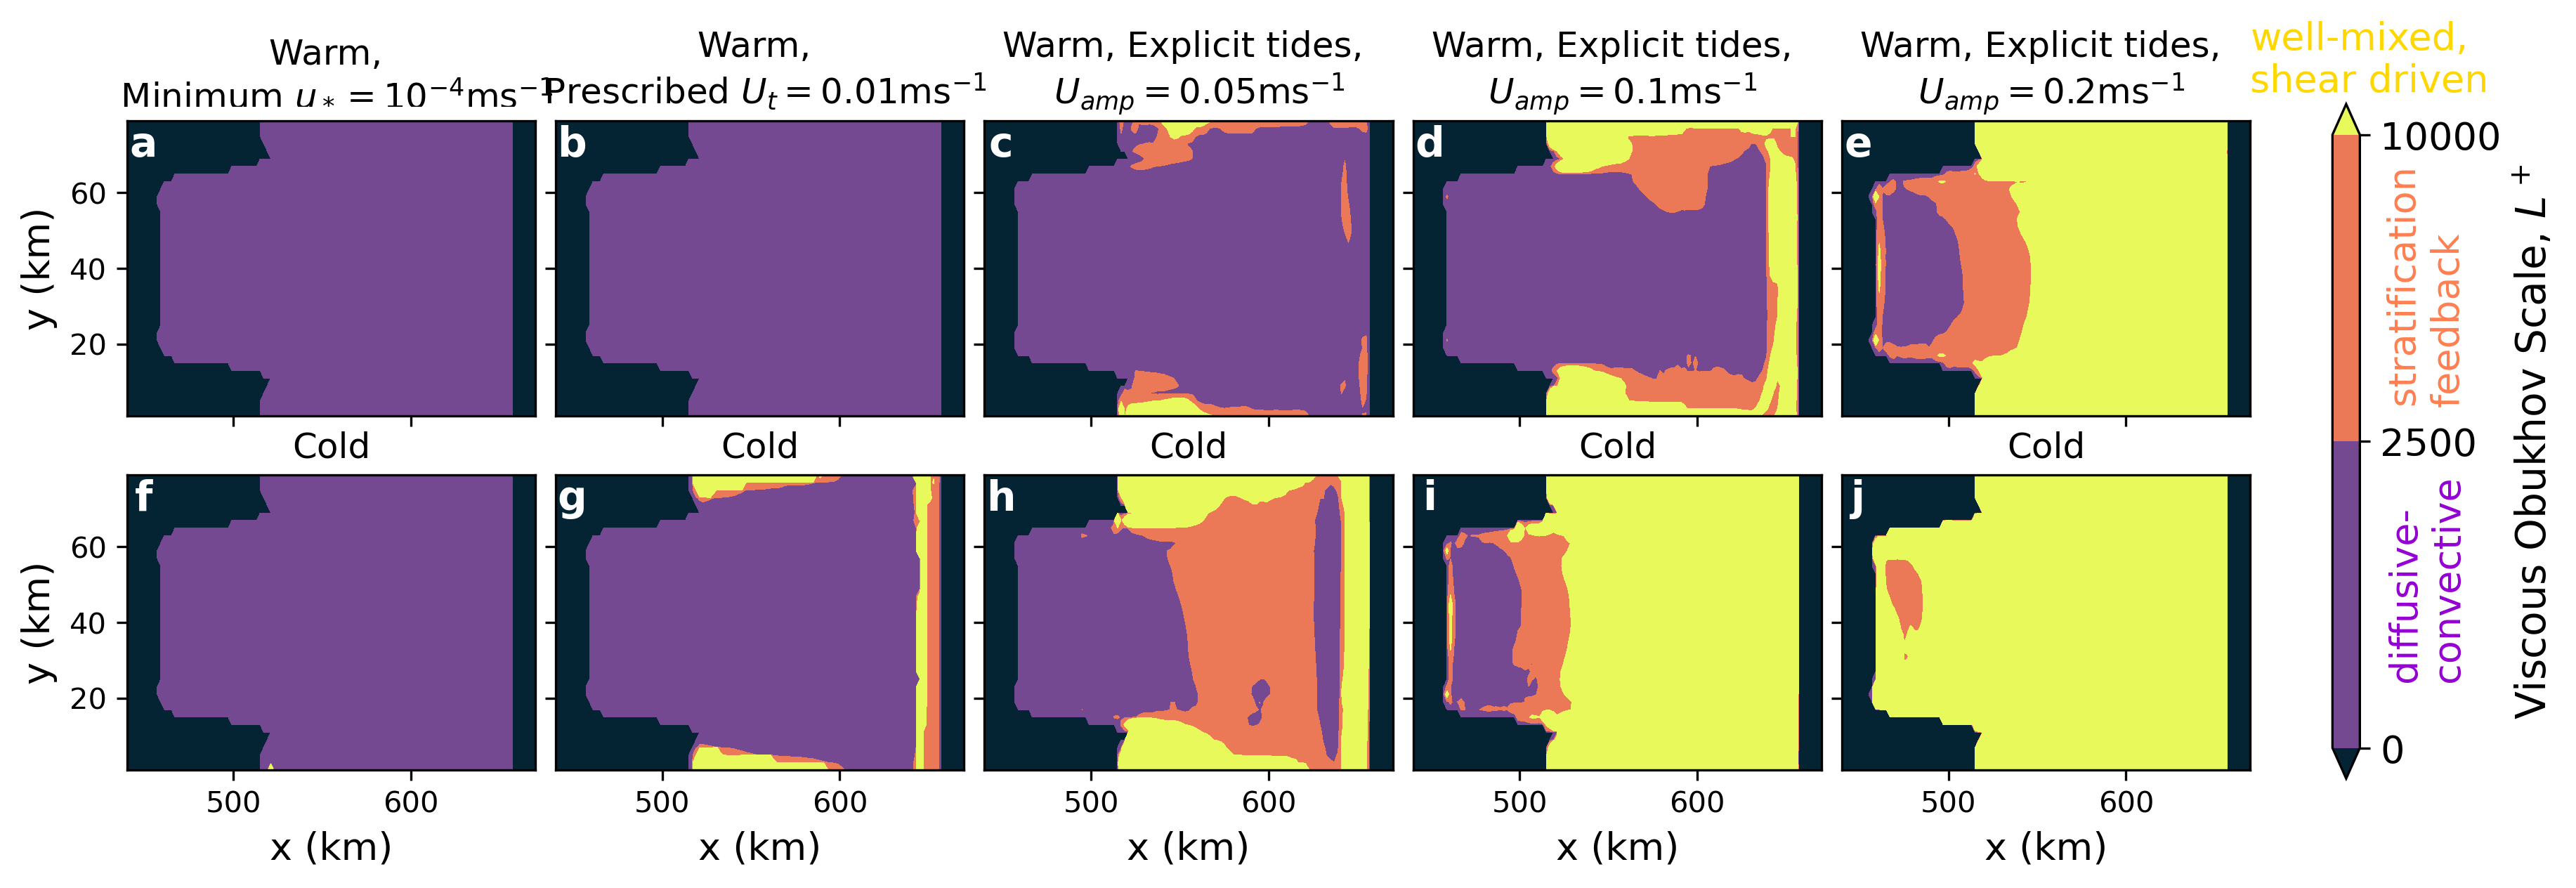

In [44]:
list_folders_base = ['layer-thermo-on-warm_CC','layer-thermo-on-cold_CC',
               'layer-thermo-on-warm_SF','layer-thermo-on-cold_SF']
suffixes = ['','-ustarmin','-u005tides','-u01tides','-u02tides']#,'-convectivelimitlocal']
list_folders = []
for n in np.arange(len(suffixes)):
    list_folders = np.append(list_folders, [x+suffixes[n] for x in list_folders_base])
print(list_folders)
list_folders_MOM6 = list_folders

fig, axes = plt.subplots(nrows = 2, ncols = 5,figsize = (13,4),dpi = 300)

time = np.arange(-180,0)
y = 20
x = 20


plot_Lplus(axes[0,1],time,2,0,4,cm.cm.thermal)
axes[0,1].set_title('Warm, \n Prescribed $U_t = 0.01$ms$^{-1}$')
plot_Lplus(axes[1,1],time,3,0,4,cm.cm.thermal)
axes[1,1].set_title('Cold')

plot_Lplus(axes[0,0],time,6,0,4,cm.cm.thermal)
axes[0,0].set_title('Warm, \n Min. $u_* = 10^{-4}$ms$^{-1}$')
plot_Lplus(axes[1,0],time,7,0,4,cm.cm.thermal)
axes[1,0].set_title('Cold')

plot_Lplus(axes[0,2],time,10,0,4,cm.cm.thermal)
axes[0,2].set_title('Warm, Explicit tides, \n '+r' $U_{amp} = 0.05$ms$^{-1}$')
plot_Lplus(axes[1,2],time,11,0,4,cm.cm.thermal)
axes[1,2].set_title('Cold')

plot_Lplus(axes[0,3],time,14,0,4,cm.cm.thermal)
axes[0,3].set_title('Warm, Explicit tides, \n '+ r'$U_{amp} = 0.1$ms$^{-1}$')
p1 = plot_Lplus(axes[1,3],time,15,0,4,cm.cm.thermal)
axes[1,3].set_title('Cold')

plot_Lplus(axes[0,4],time,18,0,4,cm.cm.thermal)
axes[0,4].set_title('Warm, Explicit tides, \n '+ r'$U_{amp} = 0.2$ms$^{-1}$')
p1 = plot_Lplus(axes[1,4],time,19,0,4,cm.cm.thermal)
axes[1,4].set_title('Cold')

cax = plt.axes([0.93,0.1,0.01,0.8])
cb = plt.colorbar(p1, cax = cax).set_label(size = 14, label = 'Viscous Obukhov Scale, $L^+$')

for j in np.arange(5):
    for k in np.arange(2):
        axes[k,j].set_xlim(440,670)

for j in np.arange(1,5):
    for k in np.arange(2):
        axes[k,j].set_ylabel('')
        axes[k,j].set_yticklabels('')

for j in np.arange(5):
    axes[0,j].set_xlabel('')
    axes[0,j].set_xticklabels('')
plt.tick_params(labelsize=13)
#plt.text(

plt.text(2,0.12, 'diffusive-\nconvective',rotation = 90,
        transform=cax.transAxes,color = 'darkviolet',fontsize = 13)
plt.text(2,0.57, 'stratification \nfeedback',rotation = 90,
        transform=cax.transAxes,color = 'coral',fontsize = 13)
plt.text(-3,1.07, 'well-mixed,\nshear driven',#rotation = 90
        transform=cax.transAxes,color = 'gold',fontsize = 13)

axes[0,0].text(0.04,0.92,'a',horizontalalignment='center', fontweight='bold',
     verticalalignment='center',transform=axes[0,0].transAxes, fontsize = 14,color = 'w')
axes[0,1].text(0.04,0.92,'b',horizontalalignment='center', fontweight='bold',
     verticalalignment='center',transform=axes[0,1].transAxes, fontsize = 14,color = 'w')
axes[0,2].text(0.04,0.92,'c',horizontalalignment='center', fontweight='bold',
     verticalalignment='center',transform=axes[0,2].transAxes, fontsize = 14,color = 'w')
axes[0,3].text(0.04,0.92,'d',horizontalalignment='center', fontweight='bold',
     verticalalignment='center',transform=axes[0,3].transAxes, fontsize = 14,color = 'w')
axes[0,4].text(0.04,0.92,'e',horizontalalignment='center', fontweight='bold',
     verticalalignment='center',transform=axes[0,4].transAxes, fontsize = 14,color = 'w')
axes[1,0].text(0.04,0.92,'f',horizontalalignment='center', fontweight='bold',
     verticalalignment='center',transform=axes[1,0].transAxes, fontsize = 14,color = 'w')
axes[1,1].text(0.04,0.92,'g',horizontalalignment='center', fontweight='bold',
     verticalalignment='center',transform=axes[1,1].transAxes, fontsize = 14,color = 'w')
axes[1,2].text(0.04,0.92,'h',horizontalalignment='center', fontweight='bold',
     verticalalignment='center',transform=axes[1,2].transAxes, fontsize = 14,color = 'w')
axes[1,3].text(0.04,0.92,'i',horizontalalignment='center', fontweight='bold',
     verticalalignment='center',transform=axes[1,3].transAxes, fontsize = 14,color = 'w')
axes[1,4].text(0.04,0.92,'j',horizontalalignment='center', fontweight='bold',
     verticalalignment='center',transform=axes[1,4].transAxes, fontsize = 14,color = 'w')


fig.subplots_adjust(hspace = 0.2,wspace = 0.05)

#### plot overturning vs melt for last 60 days

Old plot not included in submitted manuscript


(Uses old experiments -- these were rerun with a new executable)

layer-thermo-on-warm_CC
melt 1.8655399
osf 0.07218781113624573
ke 7.234355710466502e-05
layer-thermo-on-cold_CC
melt 0.05027191
osf 0.003908057697117329
ke 2.2958596715053172e-06
layer-thermo-on-warm_SF
melt 0.3424139
osf 0.03397900238633156
ke 6.989865038134414e-06
layer-thermo-on-cold_SF
melt 0.033196084
osf -0.004550474230200052
ke 2.2881660298476893e-06
layer-thermo-on-warm_CC-ustarmin
melt 0.8624517
osf 0.04235280305147171
ke 2.5128114056476348e-05
layer-thermo-on-cold_CC-ustarmin
melt 0.025190212
osf 0.00344837992452085
ke 2.3750621889039794e-06
layer-thermo-on-warm_SF-ustarmin
melt 0.022217797
osf -0.0033327534329146147
ke 2.522932805691605e-06
layer-thermo-on-cold_SF-ustarmin
melt 0.004053401
osf -0.003667361568659544
ke 2.8077695401729875e-06
layer-thermo-on-warm_CC-MK18
melt 0.8769459
osf 0.040688514709472656
ke 2.5589383789329894e-05
layer-thermo-on-cold_CC-MK18
melt 0.025274875
osf 0.003464918350800872
ke 2.3782736000617742e-06
layer-thermo-on-warm_SF-MK18
melt 0.30481163
o

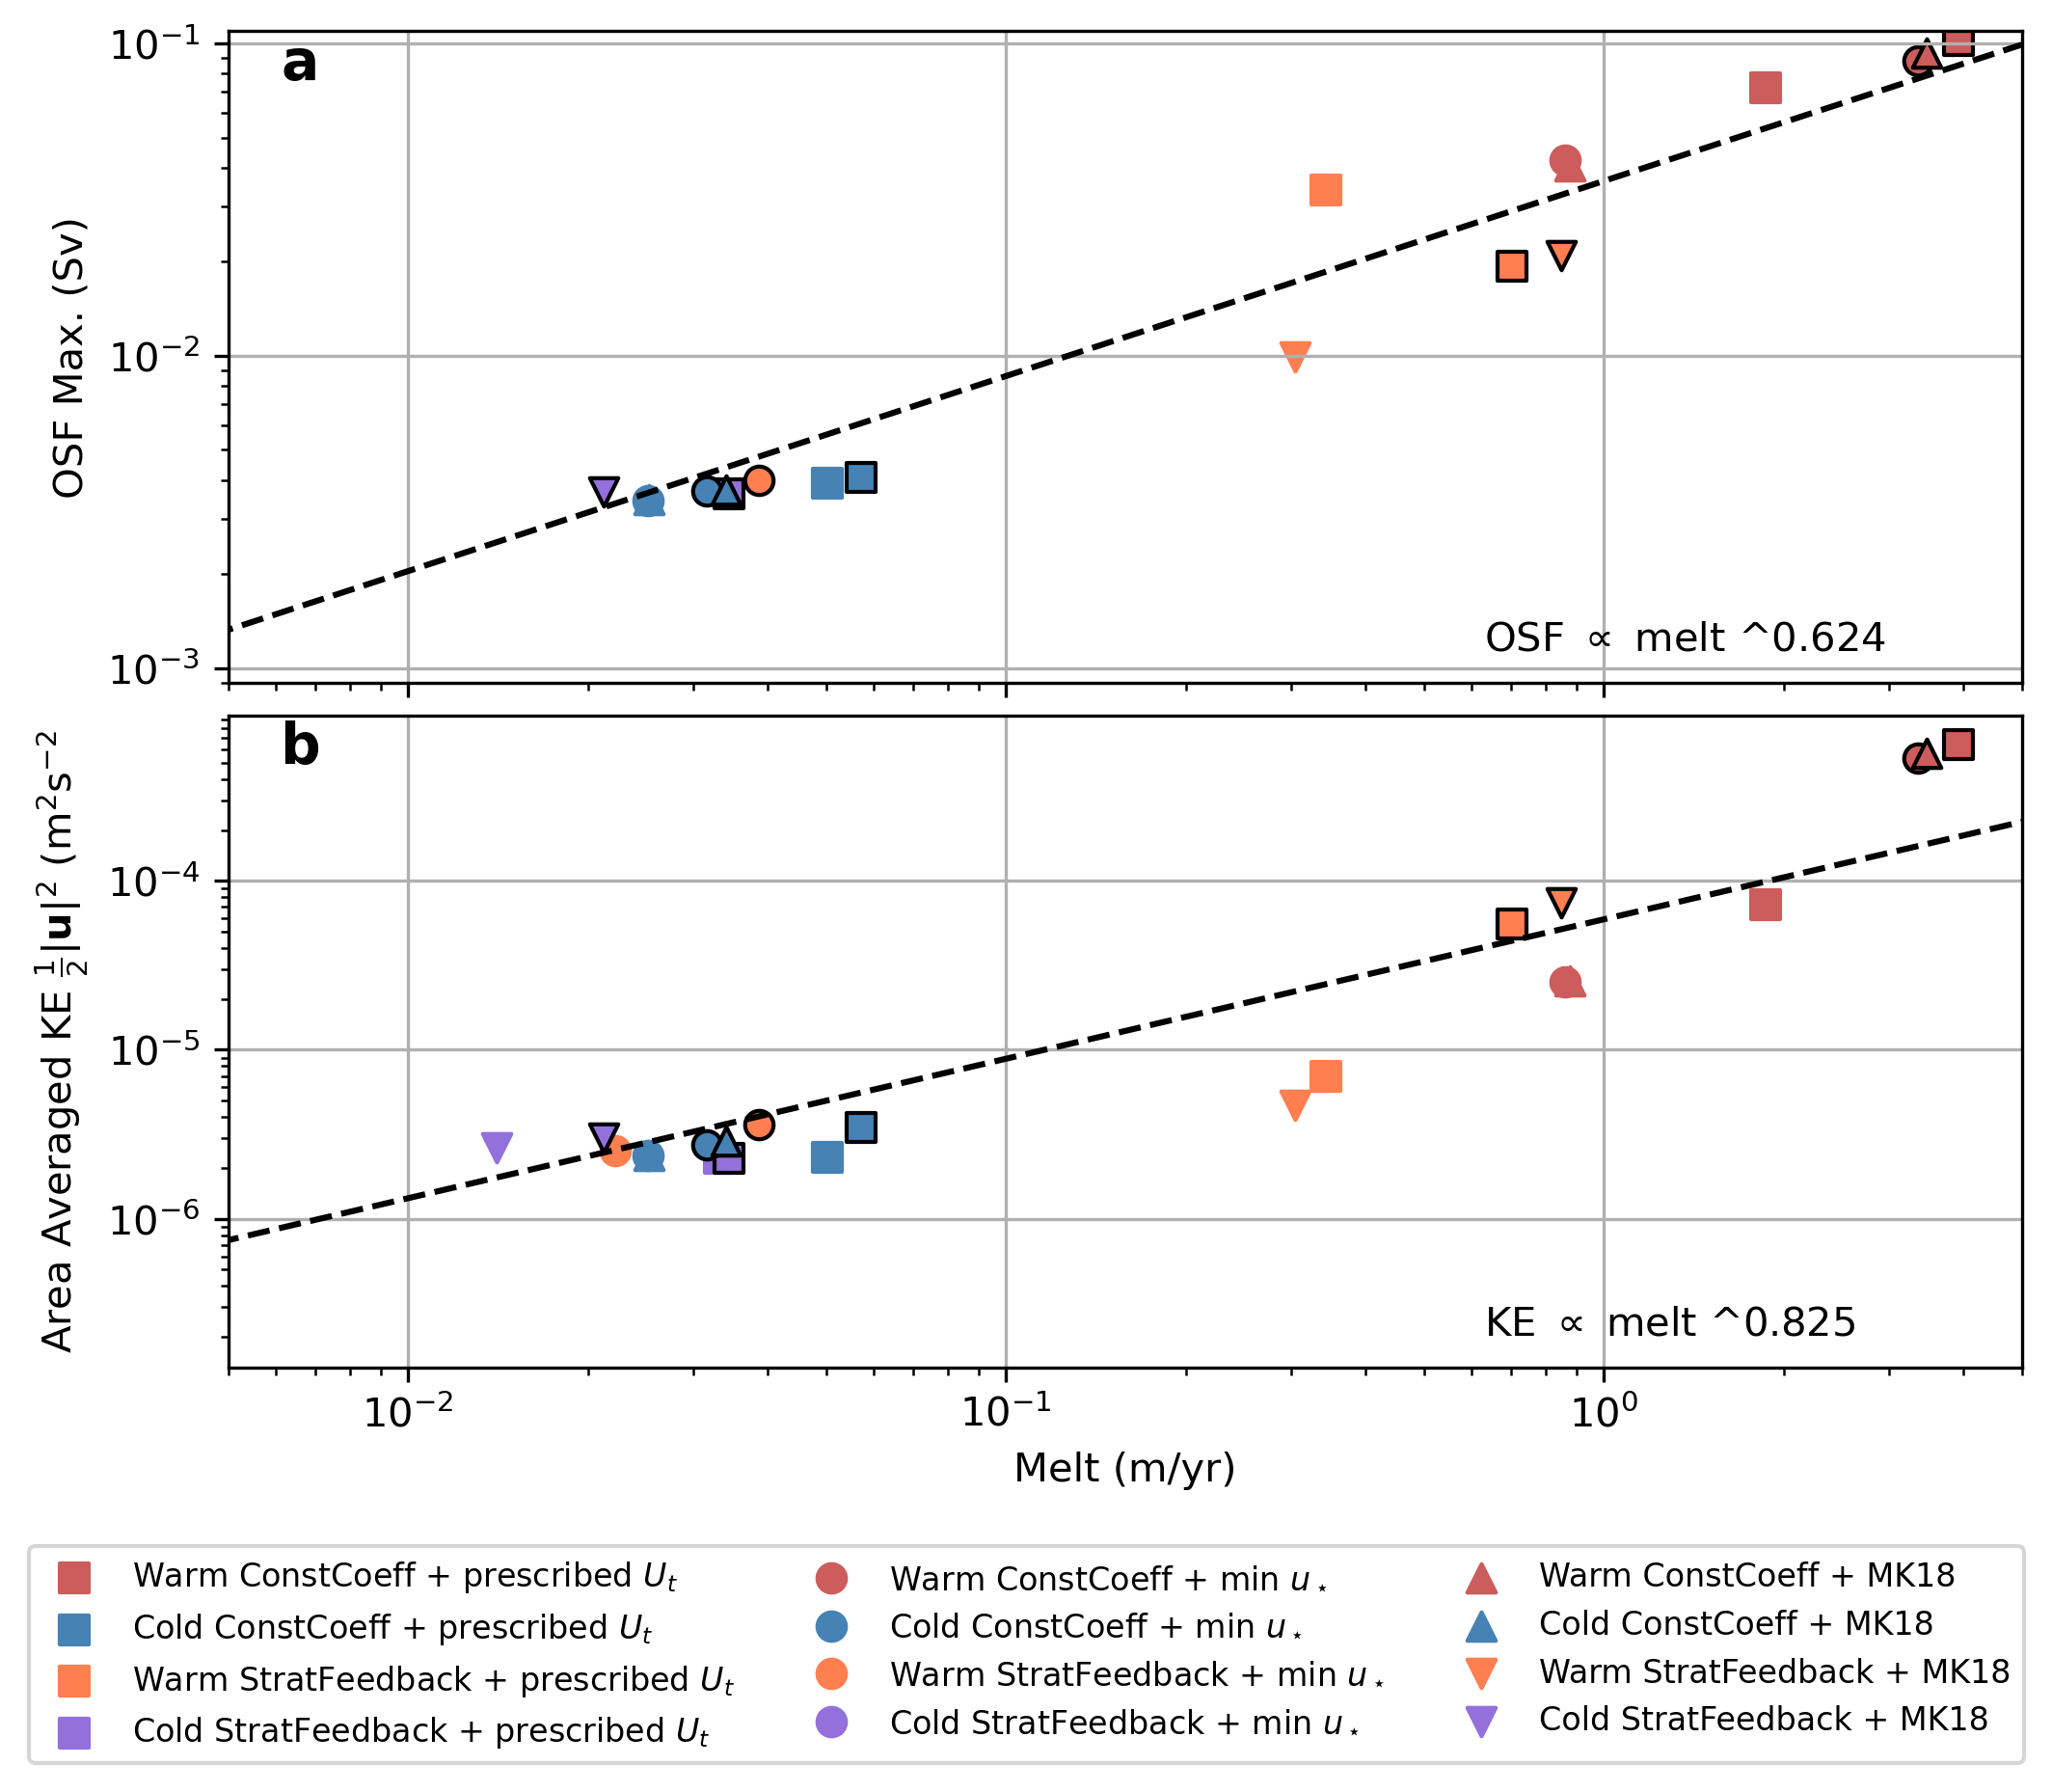

In [45]:
%%time

list_folders_MOM6 = [
                'layer-thermo-on-warm_CC', 'layer-thermo-on-cold_CC',
                'layer-thermo-on-warm_SF', 'layer-thermo-on-cold_SF',
                'layer-thermo-on-warm_CC-ustarmin', 'layer-thermo-on-cold_CC-ustarmin',
                'layer-thermo-on-warm_SF-ustarmin', 'layer-thermo-on-cold_SF-ustarmin',
                'layer-thermo-on-warm_CC-MK18', 'layer-thermo-on-cold_CC-MK18',
                'layer-thermo-on-warm_SF-MK18', 'layer-thermo-on-cold_SF-MK18',
                'layer-thermo-on-warm_R22limexdiags-tidestest-pi','layer-thermo-on-cold_R22limexdiags-tidestest-pi',
                'layer-thermo-on-warm_R22newexdiags-tidestest-pi','layer-thermo-on-cold_R22newexdiags-tidestest-pi',
                'layer-thermo-on-warm_R22limexdiags-midtides-pi','layer-thermo-on-cold_R22limexdiags-midtides-pi',
                'layer-thermo-on-warm_R22newexdiags-midtides-pi','layer-thermo-on-cold_R22newexdiags-midtides-pi',
                'layer-thermo-on-warm_R22limexdiags-lowtides-pi','layer-thermo-on-cold_R22limexdiags-lowtides-pi',
                'layer-thermo-on-warm_R22newexdiags-lowtides-pi','layer-thermo-on-cold_R22newexdiags-lowtides-pi',
                'layer-thermo-on-warm_R22limexdiags-gianttides-pi','layer-thermo-on-cold_R22limexdiags-gianttides-pi',
                'layer-thermo-on-warm_R22newexdiags-gianttides-pi','layer-thermo-on-cold_R22newexdiags-gianttides-pi',
]      


fig,axes = plt.subplots(nrows = 2, figsize = (8,6),dpi = 300, sharex = True)
# plot MOM6 results

mrs = []
kes = []
osfs = []
color_coldcc = 'steelblue'
color_warmcc = 'indianred'
color_coldsf = 'mediumpurple'
color_warmsf = 'coral'

for i in np.arange(12):
    print(list_folders_MOM6[i])
    color = [color_warmcc,color_coldcc,color_warmsf,color_coldsf,
             color_warmcc,color_coldcc,color_warmsf,color_coldsf,
             color_warmcc,color_coldcc,color_warmsf,color_coldsf,][i]
    marker = ['s','s','s','s','o','o','o','o','^','^','v','v',"d","d","d","d"][i]
    label = [r'Warm ConstCoeff + prescribed $U_t$',
             r'Cold ConstCoeff + prescribed $U_t$',
             r'Warm StratFeedback + prescribed $U_t$',
             r'Cold StratFeedback + prescribed $U_t$',
             r'Warm ConstCoeff + min $u_\star$',
             r'Cold ConstCoeff + min $u_\star$',
             r'Warm StratFeedback + min $u_\star$',
             r'Cold StratFeedback + min $u_\star$',
             r'Warm ConstCoeff + MK18',
             r'Cold ConstCoeff + MK18',
             r'Warm StratFeedback + MK18',
             r'Cold StratFeedback + MK18',][i]
    melt = compute_melt_MOM6(i,np.arange(-60,0))
    print('melt', melt)
    osf = compute_overturning_MOM6(i,np.arange(-2,0))
    print('osf', osf)
    ke = compute_KE_MOM6(i,np.arange(-60,0))
    print('ke',ke)

    mrs = np.append(melt,mrs)
    osfs = np.append(osf,osfs)
    kes = np.append(ke,kes)
    

    axes[0].scatter([melt],[osf],marker = marker,color = color, label = label,s =50)
    axes[1].scatter([melt],[ke],marker = marker,color = color, label = label,s =50)

axes[1].legend(loc = 'upper left', bbox_to_anchor = (-0.12,-0.25),ncol = 3, fontsize = 8)
axes[0].set_ylabel('OSF Max. (Sv)')
#axes[0].set_xlabel('Melt (m/yr)')
axes[1].set_xlabel('Melt (m/yr)')
axes[1].set_ylabel(r'Area Averaged KE $\frac{1}{2}|\mathbf{u}|^2$ (m$^2$s$^{-2}$')

axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].grid()
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].grid()

for i in np.arange(12):
    print(list_folders_MIT[i])
    color = [color_warmcc,color_warmsf,color_coldcc,color_coldsf,
             color_warmcc,color_warmsf,color_coldcc,color_coldsf,
             color_warmcc,color_warmsf,color_coldcc,color_coldsf,][i]
    marker = ['s','s','s','s','o','o','o','o','^','v','^','v'][i]
    label = [r'Warm CC + prescribed $U_t$',
             r'Warm SF + prescribed $U_t$',
             r'Cold CC + prescribed $U_t$',
             r'Cold SF + prescribed $U_t$',
             r'Warm CC + min$u_\star$',
             r'Warm SF + min$u_\star$',
             r'Cold CC + min$u_\star$',
             r'Cold SF + min$u_\star$',
             r'Warm CC + MK18',
             r'Warm SF + MK18',
             r'Cold CC + MK18',
             r'Cold SF + MK18'][i]
    melt = compute_melt_MIT(i,np.arange(-60,0))
    print('melt', melt)
    osf = compute_rhooverturning_MIT(i,np.arange(-60,0))
    print('osf', osf)
    ke = compute_KE_MIT(i,np.arange(-60,0))
    print('ke',ke)
    mrs = np.append(melt,mrs)
    osfs = np.append(osf,osfs)
    kes = np.append(ke,kes)

    axes[0].scatter([melt],[osf],marker = marker,color = color, label = label, edgecolor = 'k',s =50)
    axes[1].scatter([melt],[ke],marker = marker,color = color, label = label, edgecolor = 'k',s =50)


coeffs_osf = np.polyfit(np.log(mrs[osfs>0]), np.log(osfs[osfs>0]), 1)
axes[0].plot(np.linspace(1e-3,5e0),np.exp(coeffs_osf[1])*np.linspace(1e-3,5e0)**coeffs_osf[0],'--k')
coeffs_ke = np.polyfit(np.log(mrs), np.log(kes), 1)
axes[1].plot(np.linspace(1e-3,5e0),np.exp(coeffs_ke[1])*np.linspace(1e-3,5e0)**coeffs_ke[0],'--k')

# coefficients in order of highest power first: log(y) = Alog(x) + B -> y = exp(B)x^A

axes[0].text(0.7,0.05,'OSF $\propto$ melt ^'+f'{(coeffs_osf[0]):.3}', transform = axes[0].transAxes)
axes[1].text(0.7,0.05,'KE $\propto$ melt ^'+f'{(coeffs_ke[0]):.3}', transform = axes[1].transAxes)

#axes[0].plot(np.linspace(1e-3,5e0),np.linspace(1e-4,5e-1),'--k')
axes[0].set_ylim(0.9e-3,1.1e-1)
axes[0].set_xlim(5e-3,5)

axes[0].text(0.04,0.95,'a',horizontalalignment='center', fontweight='bold',
     verticalalignment='center',transform=axes[0].transAxes, fontsize = 14)
axes[1].text(0.04,0.95,'b',horizontalalignment='center', fontweight='bold',
     verticalalignment='center',transform=axes[1].transAxes, fontsize = 14)


fig.subplots_adjust(hspace = 0.05)

In [11]:
# copy data to make plot nicer since computing takes so long (note values are OLD)
# THIS IS JUST TO CHECK LOCATIONS OF LEGEND ETC


data_MOM6 = {'layer-thermo-on-warm_CC':{'melt': 1.8655399,'osf':0.07218781113624573, 'ke':7.234355710466502e-05 },
             'layer-thermo-on-cold_CC':{'melt': 0.05027191,'osf':0.003908057697117329, 'ke': 2.2958596715053172e-06},
             'layer-thermo-on-warm_SF':{'melt':0.3424139 ,'osf':0.03397900238633156, 'ke': 6.989865038134414e-06},
             'layer-thermo-on-cold_SF':{'melt':0.033196084 ,'osf':-0.004550474230200052, 'ke':2.2881660298476893e-06 },
             'layer-thermo-on-warm_CC-ustarmin':{'melt':0.8624517 ,'osf':0.04235280305147171, 'ke': 2.5128114056476348e-05},
            'layer-thermo-on-cold_CC-ustarmin':{'melt':0.025190212 ,'osf':0.00344837992452085, 'ke': 2.3750621889039794e-06},
            'layer-thermo-on-warm_SF-ustarmin':{'melt':0.022217797 ,'osf':-0.0033327534329146147, 'ke':2.522932805691605e-06 },
            'layer-thermo-on-cold_SF-ustarmin':{'melt':0.004053401 ,'osf':-0.003667361568659544, 'ke': 2.8077695401729875e-06 },
            'layer-thermo-on-warm_CC-MK18':{'melt':0.874434 ,'osf':0.04121651500463486, 'ke':2.552105166510479e-05 },
            'layer-thermo-on-cold_CC-MK18':{'melt':0.02525336 ,'osf':-0.004191403742879629, 'ke': 2.367808038049338e-06},
            'layer-thermo-on-warm_SF-MK18':{'melt':0.29362398 ,'osf':0.009568287059664726, 'ke': 4.554351406206444e-06},
            'layer-thermo-on-cold_SF-MK18':{'melt':0.013161368 ,'osf':-0.004191391635686159, 'ke':2.6685894836303245e-06 },
}

data_MIT = {'run-J10-warm-utide':{'melt':3.805257 ,'osf':0.10188843889660064, 'ke':0.0006389067},
             'run-R22-warm-utide':{'melt':0.68241715 ,'osf':0.0194047048278508, 'ke': 5.559118e-05},
            'run-J10-cold-utide':{'melt': 0.055573545,'osf':0.004088931150902201, 'ke':  3.4859843e-06},
                'run-R22-cold-utide':{'melt':0.033361923 ,'osf':0.0036088726254053256, 'ke':2.2857168e-06},
                'run-J10-warm-ustarmin':{'melt': 3.2578175,'osf':0.08830023114083965, 'ke':0.00053005223},
                'run-R22-warm-ustarmin':{'melt': 0.037559938,'osf':0.0040050008318941056, 'ke': 3.628594e-06},
                'run-J10-cold-ustarmin':{'melt': 0.030720174,'osf':0.003695835984066263, 'ke': 2.7326337e-06},
                'run-R22-cold-ustarmin':{'melt':0.004547264 ,'osf':0.0034809445361820277, 'ke':2.6553846e-06 },
           }#     '':{'melt': ,'osf':, 'ke': },
           #     '':{'melt': ,'osf':, 'ke': },
           #     '':{'melt': ,'osf':, 'ke': },
           #     '':{'melt': ,'osf':, 'ke': },
           #}


layer-thermo-on-warm_CC
melt 1.8655399
osf 0.07218781113624573
ke 7.234355710466502e-05
layer-thermo-on-cold_CC
melt 0.05027191
osf 0.003908057697117329
ke 2.2958596715053172e-06
layer-thermo-on-warm_SF
melt 0.3424139
osf 0.03397900238633156
ke 6.989865038134414e-06
layer-thermo-on-cold_SF
melt 0.033196084
osf -0.004550474230200052
ke 2.2881660298476893e-06
layer-thermo-on-warm_CC-ustarmin
melt 0.8624517
osf 0.04235280305147171
ke 2.5128114056476348e-05
layer-thermo-on-cold_CC-ustarmin
melt 0.025190212
osf 0.00344837992452085
ke 2.3750621889039794e-06
layer-thermo-on-warm_SF-ustarmin
melt 0.022217797
osf -0.0033327534329146147
ke 2.522932805691605e-06
layer-thermo-on-cold_SF-ustarmin
melt 0.004053401
osf -0.003667361568659544
ke 2.8077695401729875e-06
layer-thermo-on-warm_CC-MK18
melt 0.874434
osf 0.04121651500463486
ke 2.552105166510479e-05
layer-thermo-on-cold_CC-MK18
melt 0.02525336
osf -0.004191403742879629
ke 2.367808038049338e-06
layer-thermo-on-warm_SF-MK18
melt 0.29362398
osf 0

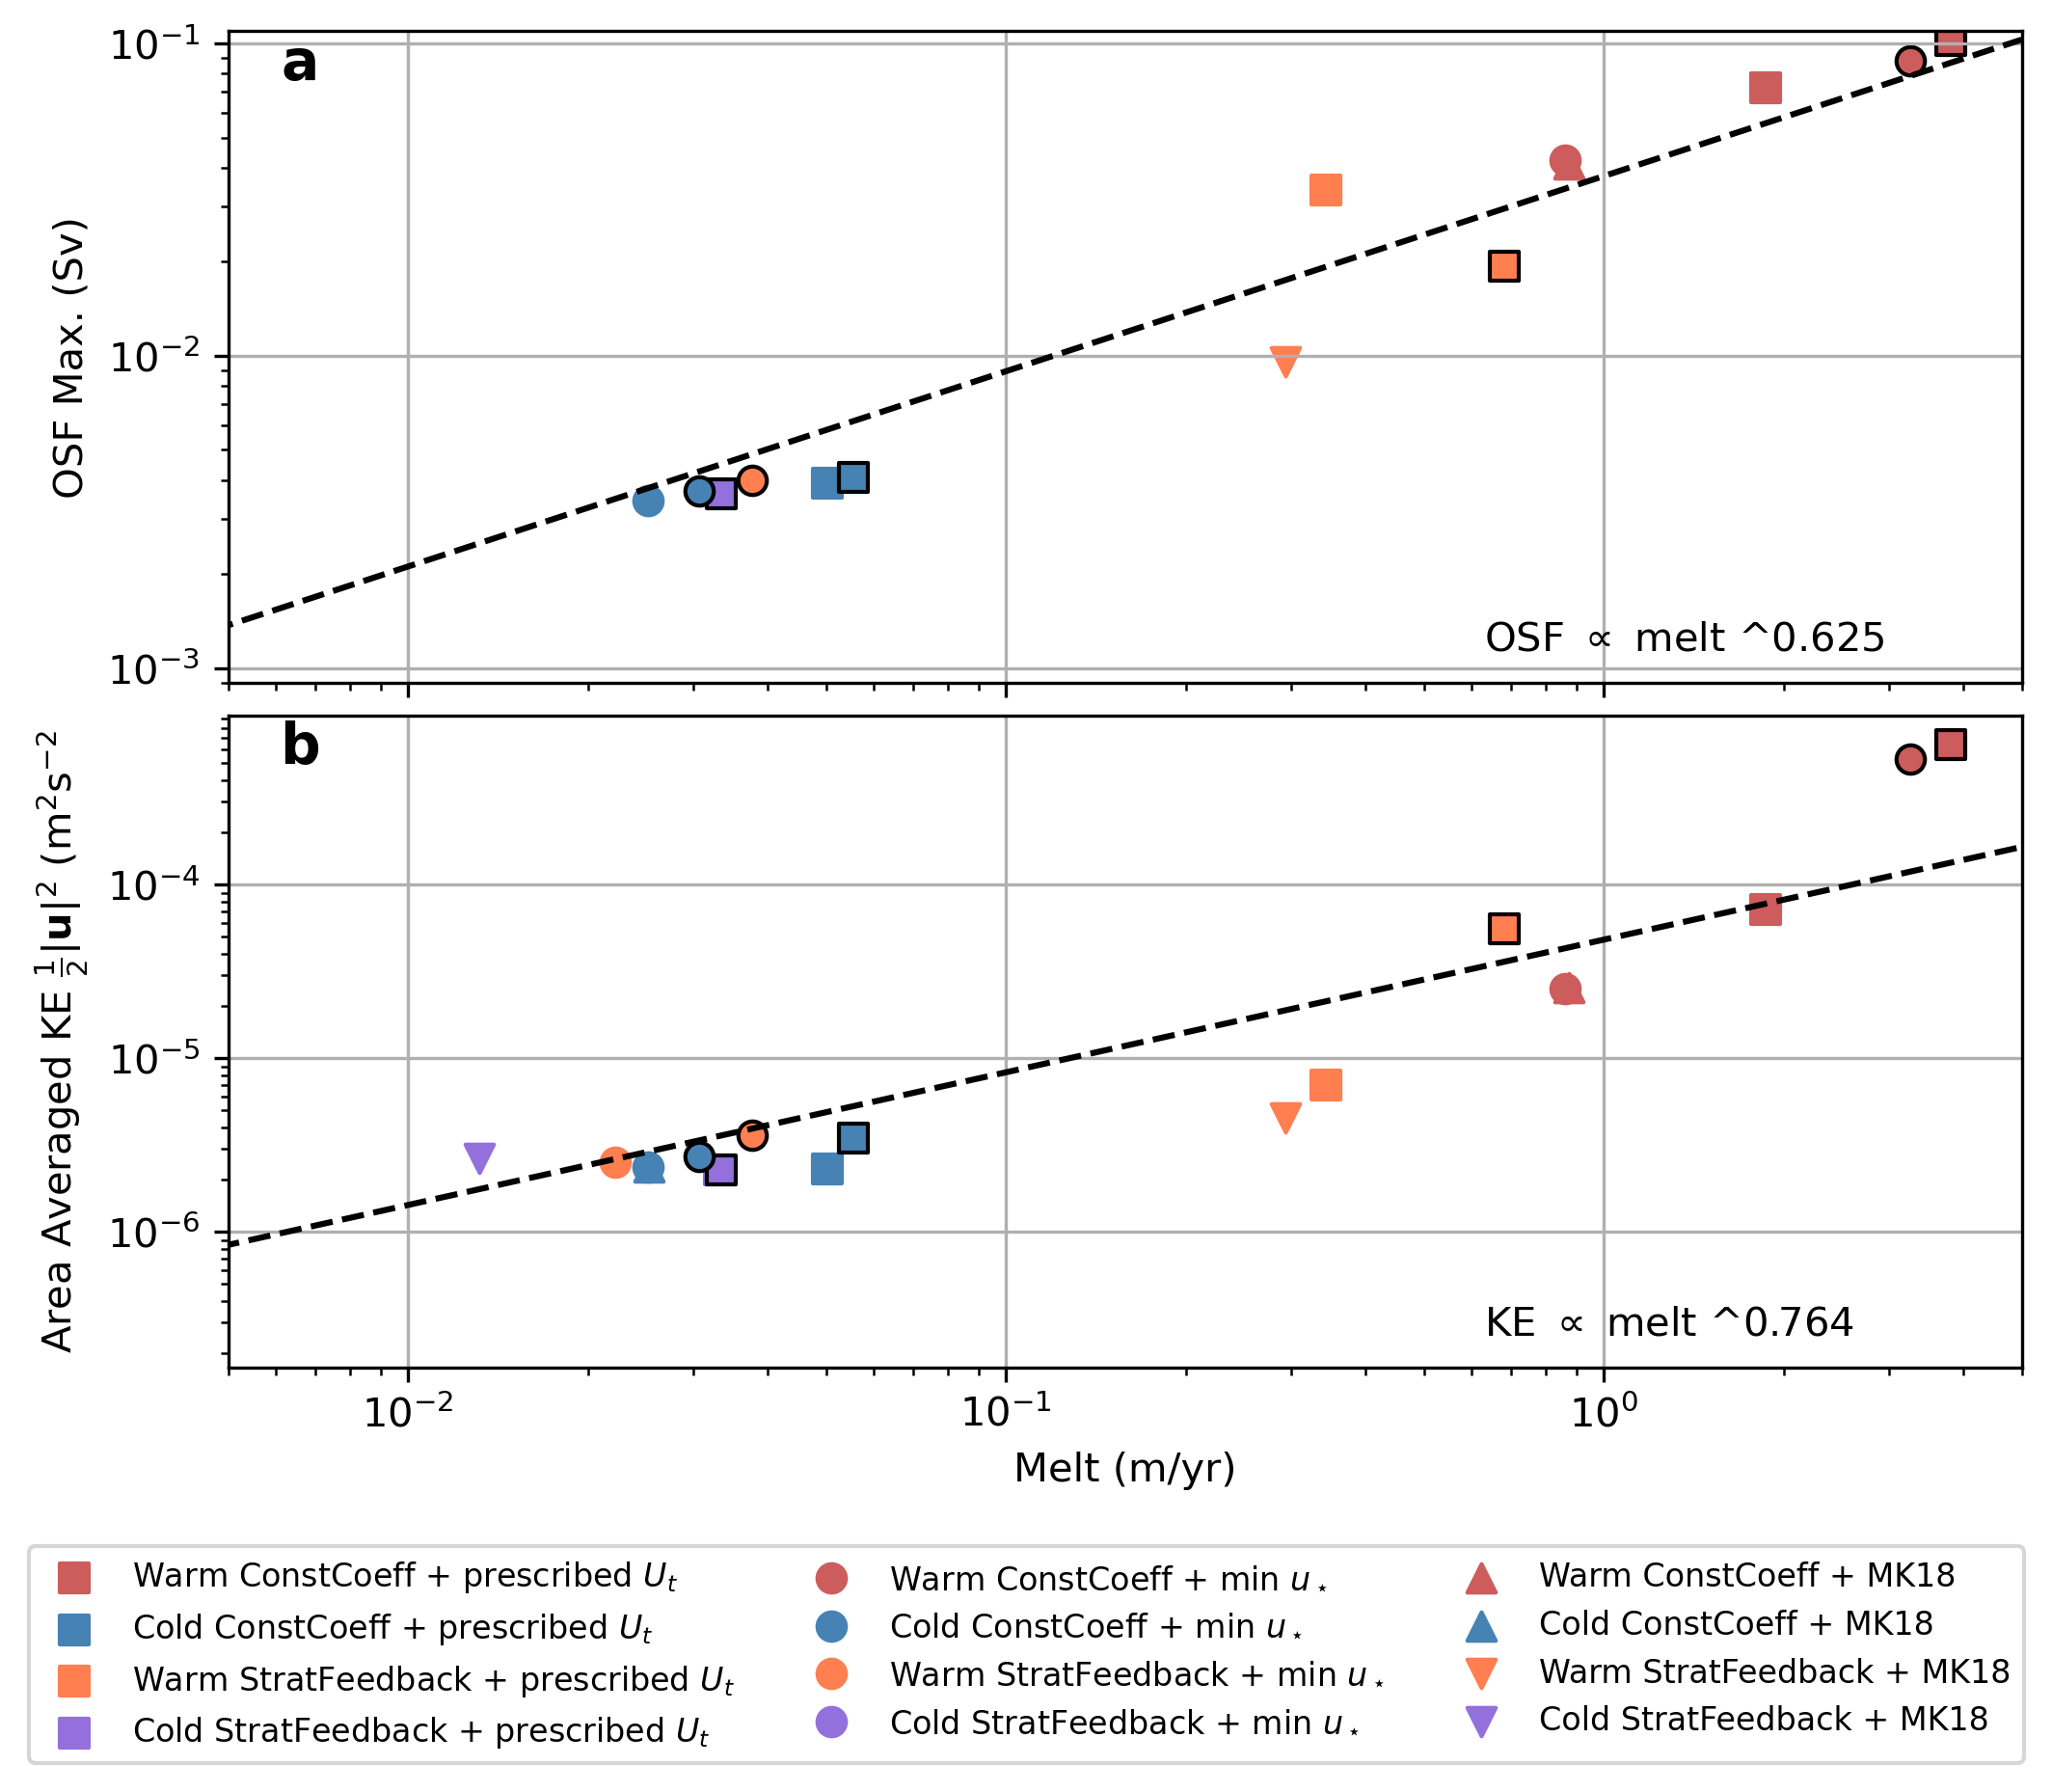

In [17]:
list_folders_MOM6 = [
                'layer-thermo-on-warm_CC', 'layer-thermo-on-cold_CC',
                'layer-thermo-on-warm_SF', 'layer-thermo-on-cold_SF',
                'layer-thermo-on-warm_CC-ustarmin', 'layer-thermo-on-cold_CC-ustarmin',
                'layer-thermo-on-warm_SF-ustarmin', 'layer-thermo-on-cold_SF-ustarmin',
                'layer-thermo-on-warm_CC-MK18', 'layer-thermo-on-cold_CC-MK18',
                'layer-thermo-on-warm_SF-MK18', 'layer-thermo-on-cold_SF-MK18',
                'layer-thermo-on-warm_R22limexdiags-tidestest-pi','layer-thermo-on-cold_R22limexdiags-tidestest-pi',
                'layer-thermo-on-warm_R22newexdiags-tidestest-pi','layer-thermo-on-cold_R22newexdiags-tidestest-pi',
                'layer-thermo-on-warm_R22limexdiags-midtides-pi','layer-thermo-on-cold_R22limexdiags-midtides-pi',
                'layer-thermo-on-warm_R22newexdiags-midtides-pi','layer-thermo-on-cold_R22newexdiags-midtides-pi',
                'layer-thermo-on-warm_R22limexdiags-lowtides-pi','layer-thermo-on-cold_R22limexdiags-lowtides-pi',
                'layer-thermo-on-warm_R22newexdiags-lowtides-pi','layer-thermo-on-cold_R22newexdiags-lowtides-pi',
                'layer-thermo-on-warm_R22limexdiags-gianttides-pi','layer-thermo-on-cold_R22limexdiags-gianttides-pi',
                'layer-thermo-on-warm_R22newexdiags-gianttides-pi','layer-thermo-on-cold_R22newexdiags-gianttides-pi',
]      


fig,axes = plt.subplots(nrows = 2, figsize = (8,6),dpi = 300, sharex = True)
# plot MOM6 results

mrs = []
kes = []
osfs = []
color_coldcc = 'steelblue'
color_warmcc = 'indianred'
color_coldsf = 'mediumpurple'
color_warmsf = 'coral'

for i in np.arange(12):
    print(list_folders_MOM6[i])
    color = [color_warmcc,color_coldcc,color_warmsf,color_coldsf,
             color_warmcc,color_coldcc,color_warmsf,color_coldsf,
             color_warmcc,color_coldcc,color_warmsf,color_coldsf,][i]
    marker = ['s','s','s','s','o','o','o','o','^','^','v','v',"d","d","d","d"][i]
    label = [r'Warm ConstCoeff + prescribed $U_t$',
             r'Cold ConstCoeff + prescribed $U_t$',
             r'Warm StratFeedback + prescribed $U_t$',
             r'Cold StratFeedback + prescribed $U_t$',
             r'Warm ConstCoeff + min $u_\star$',
             r'Cold ConstCoeff + min $u_\star$',
             r'Warm StratFeedback + min $u_\star$',
             r'Cold StratFeedback + min $u_\star$',
             r'Warm ConstCoeff + MK18',
             r'Cold ConstCoeff + MK18',
             r'Warm StratFeedback + MK18',
             r'Cold StratFeedback + MK18',][i]
    melt = data_MOM6[list_folders_MOM6[i]]['melt']#compute_melt_MOM6(i,np.arange(-60,0))
    print('melt', melt)
    osf = data_MOM6[list_folders_MOM6[i]]['osf']#compute_overturning_MOM6(i,np.arange(-2,0))
    print('osf', osf)
    ke = data_MOM6[list_folders_MOM6[i]]['ke']#compute_KE_MOM6(i,np.arange(-60,0))
    print('ke',ke)

    mrs = np.append(melt,mrs)
    osfs = np.append(osf,osfs)
    kes = np.append(ke,kes)
    

    axes[0].scatter([melt],[osf],marker = marker,color = color, label = label, s = 50)
    axes[1].scatter([melt],[ke],marker = marker,color = color, label = label, s = 50)

axes[1].legend(loc = 'upper left', bbox_to_anchor = (-0.12,-0.25),ncol = 3, fontsize = 8)
axes[0].set_ylabel('OSF Max. (Sv)')
#axes[0].set_xlabel('Melt (m/yr)')
axes[1].set_xlabel('Melt (m/yr)')
axes[1].set_ylabel(r'Area Averaged KE $\frac{1}{2}|\mathbf{u}|^2$ (m$^2$s$^{-2}$')

axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].grid()
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].grid()

for i in np.arange(8):
    print(list_folders_MIT[i])
    color = [color_warmcc,color_warmsf,color_coldcc,color_coldsf,
             color_warmcc,color_warmsf,color_coldcc,color_coldsf,][i]
    marker = ['s','s','s','s','o','o','o','o'][i]
    label = [r'Warm CC + prescribed $U_t$',
             r'Warm SF + prescribed $U_t$',
             r'Cold CC + prescribed $U_t$',
             r'Cold SF + prescribed $U_t$',
             r'Warm CC + min$u_\star$',
             r'Warm SF + min$u_\star$',
             r'Cold CC + min$u_\star$',
             r'Cold SF + min$u_\star$'][i]
    melt = data_MIT[list_folders_MIT[i]]['melt']#compute_melt_MIT(i,np.arange(-60,0))
    print('melt', melt)
    osf = data_MIT[list_folders_MIT[i]]['osf']#compute_rhooverturning_MIT(i,np.arange(-60,0))
    print('osf', osf)
    ke = data_MIT[list_folders_MIT[i]]['ke']#compute_KE_MIT(i,np.arange(-60,0))
    print('ke',ke)
    mrs = np.append(melt,mrs)
    osfs = np.append(osf,osfs)
    kes = np.append(ke,kes)

    axes[0].scatter([melt],[osf],marker = marker,color = color, label = label, edgecolor = 'k', s = 50)
    axes[1].scatter([melt],[ke],marker = marker,color = color, label = label, edgecolor = 'k', s = 50)


coeffs_osf = np.polyfit(np.log(mrs[osfs>0]), np.log(osfs[osfs>0]), 1)
axes[0].plot(np.linspace(1e-3,5e0),np.exp(coeffs_osf[1])*np.linspace(1e-3,5e0)**coeffs_osf[0],'--k')
coeffs_ke = np.polyfit(np.log(mrs), np.log(kes), 1)
axes[1].plot(np.linspace(1e-3,5e0),np.exp(coeffs_ke[1])*np.linspace(1e-3,5e0)**coeffs_ke[0],'--k')

# coefficients in order of highest power first: log(y) = Alog(x) + B -> y = exp(B)x^A

axes[0].text(0.7,0.05,'OSF $\propto$ melt ^'+f'{(coeffs_osf[0]):.3}', transform = axes[0].transAxes)
axes[1].text(0.7,0.05,'KE $\propto$ melt ^'+f'{(coeffs_ke[0]):.3}', transform = axes[1].transAxes)

#axes[0].plot(np.linspace(1e-3,5e0),np.linspace(1e-4,5e-1),'--k')
axes[0].set_ylim(0.9e-3,1.1e-1)
axes[0].set_xlim(5e-3,5)

axes[0].text(0.04,0.95,'a',horizontalalignment='center', fontweight='bold',
     verticalalignment='center',transform=axes[0].transAxes, fontsize = 14)
axes[1].text(0.04,0.95,'b',horizontalalignment='center', fontweight='bold',
     verticalalignment='center',transform=axes[1].transAxes, fontsize = 14)


fig.subplots_adjust(hspace = 0.05)